# MSc Thesis Simulations

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math

C:\Users\armaa\AppData\Local\Temp\ipykernel_7892\927547141.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# FairBandits Algorithm

## Simulation 1

In [2]:
class UCB1:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = [0 for i in range(n_arms)]
        self.values = [0.0 for i in range(n_arms)]

    def select_arm(self):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm              # Play each arm once initially

        total_counts = sum(self.counts)
        ucb_values = [0.0 for i in range(self.n_arms)]

        for arm in range(self.n_arms):
            B = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + B

        return ucb_values.index(max(ucb_values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]

        # Update the empirical mean reward
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward



In [3]:
class FairBandits:
    def __init__(self, n_arms, delta):
        self.n_arms = n_arms
        self.delta = delta
        self.counts = [0 for i in range(n_arms)]
        self.values = [0.5 for i in range(n_arms)]
        self.upper_bounds = [1.0 for i in range(n_arms)]
        self.lower_bounds = [0.0 for i in range(n_arms)]
        self.active_set = set(range(n_arms))

    def select_arm(self):

        # Find the arm with the highest UCB
        arm_max_ucb = max(self.active_set, key=lambda arm: self.upper_bounds[arm])

        #print(arm_max_ucb)
        
        # Find all chained arms to arm with max ucb
        chained_arms = self.find_chained_arms(arm_max_ucb)
        
        # Update active set to be the chained arms
        self.active_set = chained_arms
        self.active_set.add(arm_max_ucb)
        
        # Select an arm uniformly at random from the chained arms
        return np.random.choice(list(chained_arms))

    def find_chained_arms(self, start_arm):
        # Build the graph of linked arms
        
        G = nx.Graph()
        
            
        #for arms in self.active_set:
        #    G.add_node(arms)
        
        G.add_nodes_from(self.active_set)
            
        
        for arm1 in self.active_set:
            for arm2 in self.active_set:    
                arm1_interval = pd.Interval(self.lower_bounds[arm1], self.upper_bounds[arm1], closed='both')
                arm2_interval = pd.Interval(self.lower_bounds[arm2], self.upper_bounds[arm2], closed='both')

                if arm1 != arm2 and arm1_interval.overlaps(arm2_interval):
                    G.add_edge(arm1, arm2)
        
            
            
        # Use DFS to find chained arms to arm_max_ucb
        chained_arms = list(nx.dfs_preorder_nodes(G, source=start_arm))

        return set(chained_arms)
    
    

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        # Update the empirical mean reward
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
        
        # Update confidence intervals
        B = np.sqrt(np.log(((np.pi * (np.sum(self.counts) + 1))**2) / (3 * self.delta)) / (2 * n))   
        self.upper_bounds[chosen_arm] = self.values[chosen_arm] + B
        self.lower_bounds[chosen_arm] = self.values[chosen_arm] - B


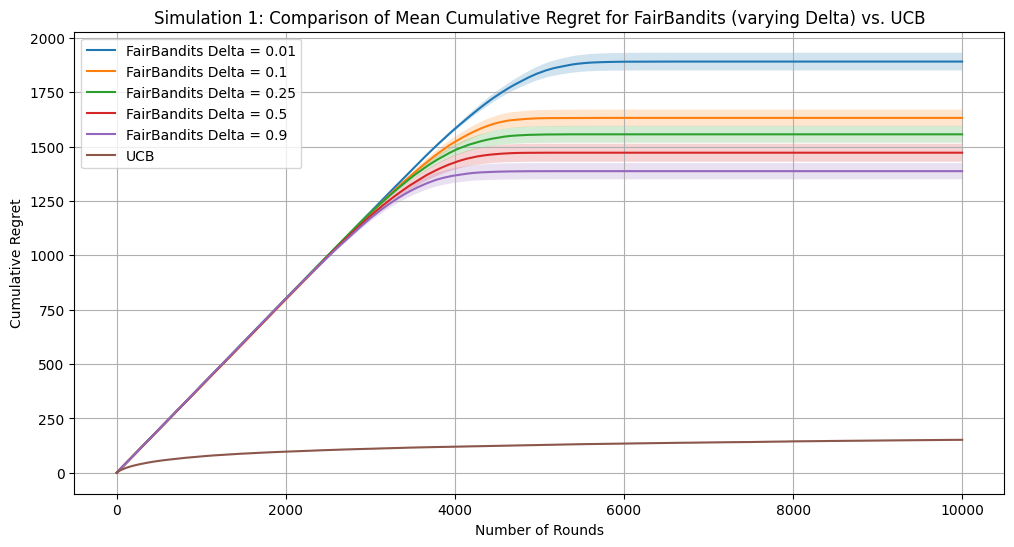

In [11]:
def calculate_current_regret(best_arm_mean, chosen_arm_mean):
    return best_arm_mean - chosen_arm_mean

# Simulate Bandit Function (Updated for UCB1 inclusion)
def simulate_bandit(n_arms, n_rounds, success_probs, delta, n_simulations):
    best_arm_mean = max(success_probs)
    all_cumulative_regrets_fair = []
    all_cumulative_regrets_ucb1 = []

    for _ in range(n_simulations):
        fair_bandit = FairBandits(n_arms, delta)
        ucb1_bandit = UCB1(n_arms)
        cumulative_regret_fair = 0
        cumulative_regret_ucb1 = 0
        cumulative_regret_sequence_fair = []
        cumulative_regret_sequence_ucb1 = []

        for t in range(n_rounds):
            # FairBandits arm selection and update
            arm_fair = fair_bandit.select_arm()
            reward_fair = np.random.binomial(1, success_probs[arm_fair])
            fair_bandit.update(arm_fair, reward_fair)
            chosen_arm_mean_fair = success_probs[arm_fair]
            cumulative_regret_fair += calculate_current_regret(best_arm_mean, chosen_arm_mean_fair)
            cumulative_regret_sequence_fair.append(cumulative_regret_fair)

            # UCB1 arm selection and update
            arm_ucb1 = ucb1_bandit.select_arm()
            reward_ucb1 = np.random.binomial(1, success_probs[arm_ucb1])
            ucb1_bandit.update(arm_ucb1, reward_ucb1)
            chosen_arm_mean_ucb1 = success_probs[arm_ucb1]
            cumulative_regret_ucb1 += calculate_current_regret(best_arm_mean, chosen_arm_mean_ucb1)
            cumulative_regret_sequence_ucb1.append(cumulative_regret_ucb1)

        all_cumulative_regrets_fair.append(cumulative_regret_sequence_fair)
        all_cumulative_regrets_ucb1.append(cumulative_regret_sequence_ucb1)

    all_cumulative_regrets_fair = np.array(all_cumulative_regrets_fair)
    all_cumulative_regrets_ucb1 = np.array(all_cumulative_regrets_ucb1)

    mean_cumulative_regret_fair = np.mean(all_cumulative_regrets_fair, axis=0)
    std_error_regret_fair = np.std(all_cumulative_regrets_fair, axis=0) / np.sqrt(n_simulations)

    mean_cumulative_regret_ucb1 = np.mean(all_cumulative_regrets_ucb1, axis=0)
    std_error_regret_ucb1 = np.std(all_cumulative_regrets_ucb1, axis=0) / np.sqrt(n_simulations)

    return mean_cumulative_regret_fair, std_error_regret_fair, mean_cumulative_regret_ucb1, std_error_regret_ucb1

# Parameters
n_arms = 5
n_rounds = 10000
success_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 100

# Run simulations and plot results
plt.figure(figsize=(12, 6))

for delta in delta_values:
    mean_regret_fair, std_error_fair, mean_regret_ucb1, std_error_ucb1 = simulate_bandit(n_arms, n_rounds, success_probs, delta, n_simulations)
    
    # Plot FairBandits results
    plt.plot(mean_regret_fair, label=f'FairBandits Delta = {delta}')
    plt.fill_between(range(n_rounds), mean_regret_fair - 2 * std_error_fair, mean_regret_fair + 2 * std_error_fair, alpha=0.2)

# Plot UCB1 results
plt.plot(mean_regret_ucb1, label='UCB')
plt.fill_between(range(n_rounds), mean_regret_ucb1 - 2 * std_error_ucb1, mean_regret_ucb1 + 2 * std_error_ucb1, alpha=0.2)

plt.xlabel('Number of Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Simulation 1: Comparison of Mean Cumulative Regret for FairBandits (varying Delta) vs. UCB')
plt.legend()
plt.grid(True)
plt.show()

### Should regret be calculated using mean reward from all active arms?
### ADD UCB
### Standard errors instead

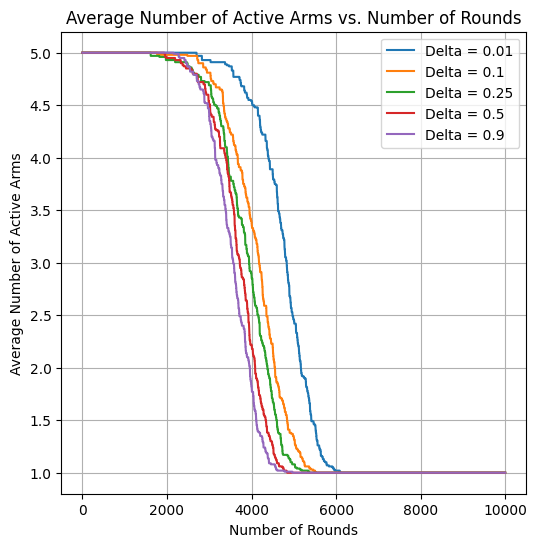

In [76]:
### Add mean number of active arms too at each round 

# Parameters
n_arms = 5
n_rounds = 10000
success_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 100

# Storage for active arm counts
mean_active_arm_counts = {delta: np.zeros(n_rounds) for delta in delta_values}

for delta in delta_values:
    all_active_arm_counts = []

    for _ in range(n_simulations):
        fair_bandit = FairBandits(n_arms, delta)
        active_arm_counts = []

        for t in range(n_rounds):
            arm = fair_bandit.select_arm()
            reward = np.random.binomial(1, success_probs[arm])
            fair_bandit.update(arm, reward)

            active_arm_counts.append(len(fair_bandit.active_set))

        all_active_arm_counts.append(active_arm_counts)

    # Compute the mean number of active arms across all simulations
    mean_active_arm_counts[delta] = np.mean(all_active_arm_counts, axis=0)

# Plotting the number of active arms
plt.figure(figsize=(6, 6))
for delta in delta_values:
    plt.plot(mean_active_arm_counts[delta], label=f'Delta = {delta}')

plt.xlabel('Number of Rounds')
plt.ylabel('Average Number of Active Arms')
plt.title('Average Number of Active Arms vs. Number of Rounds')
plt.legend()
plt.grid(True)
plt.show()


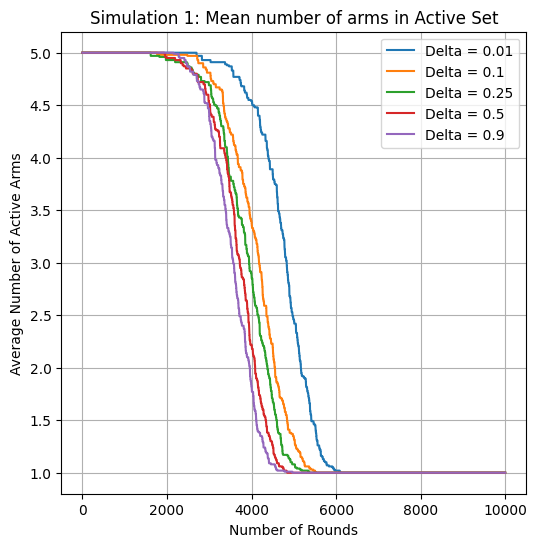

In [87]:
# Plotting the number of active arms
plt.figure(figsize=(6, 6))
for delta in delta_values:
    plt.plot(mean_active_arm_counts[delta], label=f'Delta = {delta}')

plt.xlabel('Number of Rounds')
plt.ylabel('Average Number of Active Arms')
plt.title('Simulation 1: Mean number of arms in Active Set')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
### Add mean probability of selecting best arm

import numpy as np
import matplotlib.pyplot as plt
import math

def plot_best_arm_probability(fair_bandit_class, ucb_bandit_class, success_probs, n_rounds, delta_values, n_simulations):
    plt.figure(figsize=(6, 6))
    best_arm = np.argmax(success_probs)

    # Plot for FairBandits with different delta values
    for delta in delta_values:
        best_arm_probabilities_all_simulations = np.zeros(n_rounds)
        
        for _ in range(n_simulations):
            fair_bandit = fair_bandit_class(len(success_probs), delta)
            best_arm_probabilities = np.zeros(n_rounds)
            
            for t in range(n_rounds):
                arm = fair_bandit.select_arm()
                reward = np.random.binomial(1, success_probs[arm])
                fair_bandit.update(arm, reward)
                best_arm_probabilities[t] = (arm == best_arm)
            
            # Accumulate the probabilities over all simulations
            best_arm_probabilities_all_simulations += best_arm_probabilities
        
        # Calculate the mean probability across all simulations
        mean_best_arm_probabilities = best_arm_probabilities_all_simulations / n_simulations
        
        # Plot cumulative empirical probability
        plt.plot(np.cumsum(mean_best_arm_probabilities) / (np.arange(n_rounds) + 1), label=f'FairBandits Delta = {delta}')
    
    # Plot for UCB1
    best_arm_probabilities_all_simulations_ucb1 = np.zeros(n_rounds)
    
    for _ in range(n_simulations):
        ucb_bandit = ucb_bandit_class(len(success_probs))
        best_arm_probabilities_ucb1 = np.zeros(n_rounds)
        
        for t in range(n_rounds):
            arm = ucb_bandit.select_arm()
            reward = np.random.binomial(1, success_probs[arm])
            ucb_bandit.update(arm, reward)
            best_arm_probabilities_ucb1[t] = (arm == best_arm)
        
        # Accumulate the probabilities over all simulations
        best_arm_probabilities_all_simulations_ucb1 += best_arm_probabilities_ucb1
    
    # Calculate the mean probability across all simulations for UCB1
    mean_best_arm_probabilities_ucb1 = best_arm_probabilities_all_simulations_ucb1 / n_simulations
    
    # Plot cumulative empirical probability for UCB1
    plt.plot(np.cumsum(mean_best_arm_probabilities_ucb1) / (np.arange(n_rounds) + 1), label='UCB1')
    
    plt.xlabel('Round')
    plt.ylabel('Empirical Probability Best Arm is Played')
    plt.title('Simulation 1: Cumulative Probability of Selecting Best Arm')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
n_arms = 5
n_rounds = 10000
success_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 50

# Plot the probability of selecting the best arm
plot_best_arm_probability(FairBandits, UCB1, success_probs, n_rounds, delta_values, n_simulations)




KeyboardInterrupt: 

<Figure size 600x600 with 0 Axes>

# Simulation 2 - Closer mean values

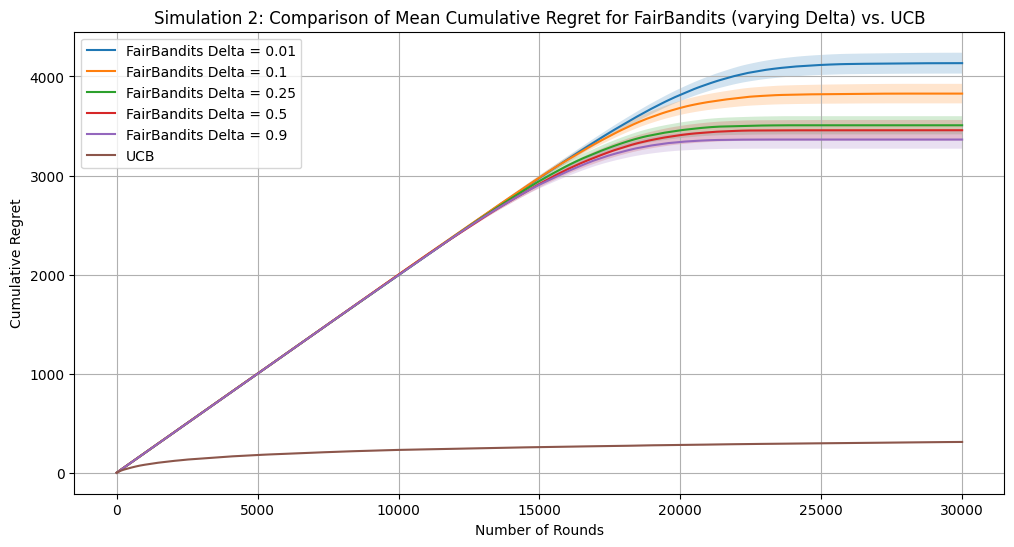

In [12]:
# Parameters
n_arms = 5
n_rounds = 30000
success_probs = [0.3, 0.4, 0.5, 0.6, 0.7]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 100

# Run simulations and plot results
plt.figure(figsize=(12, 6))

for delta in delta_values:
    mean_regret_fair, std_error_fair, mean_regret_ucb1, std_error_ucb1 = simulate_bandit(n_arms, n_rounds, success_probs, delta, n_simulations)
    
    # Plot FairBandits results
    plt.plot(mean_regret_fair, label=f'FairBandits Delta = {delta}')
    plt.fill_between(range(n_rounds), mean_regret_fair - 2 * std_error_fair, mean_regret_fair + 2 * std_error_fair, alpha=0.2)

# Plot UCB1 results
plt.plot(mean_regret_ucb1, label='UCB')
plt.fill_between(range(n_rounds), mean_regret_ucb1 - 2 * std_error_ucb1, mean_regret_ucb1 + 2 * std_error_ucb1, alpha=0.2)

plt.xlabel('Number of Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Simulation 2: Comparison of Mean Cumulative Regret for FairBandits (varying Delta) vs. UCB') 
plt.legend()
plt.grid(True)
plt.show()

### Should regret be calculated using mean reward from all active arms?
### ADD UCB
### Standard errors instead

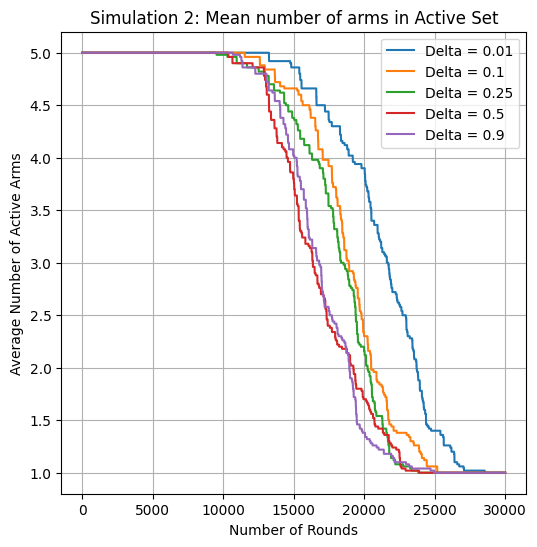

In [92]:
n_arms = 5
n_rounds = 30000
success_probs = [0.3, 0.4, 0.5, 0.6, 0.7]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 50

mean_active_arm_counts = {delta: np.zeros(n_rounds) for delta in delta_values}

for delta in delta_values:
    all_active_arm_counts = []

    for _ in range(n_simulations):
        fair_bandit = FairBandits(n_arms, delta)
        active_arm_counts = []

        for t in range(n_rounds):
            arm = fair_bandit.select_arm()
            reward = np.random.binomial(1, success_probs[arm])
            fair_bandit.update(arm, reward)

            active_arm_counts.append(len(fair_bandit.active_set))

        all_active_arm_counts.append(active_arm_counts)

    # Compute the mean number of active arms across all simulations
    mean_active_arm_counts[delta] = np.mean(all_active_arm_counts, axis=0)

# Plotting the number of active arms
plt.figure(figsize=(6, 6))
for delta in delta_values:
    plt.plot(mean_active_arm_counts[delta], label=f'Delta = {delta}')

plt.xlabel('Number of Rounds')
plt.ylabel('Average Number of Active Arms')
plt.title('Simulation 2: Mean number of arms in Active Set')
plt.legend()
plt.grid(True)
plt.show()

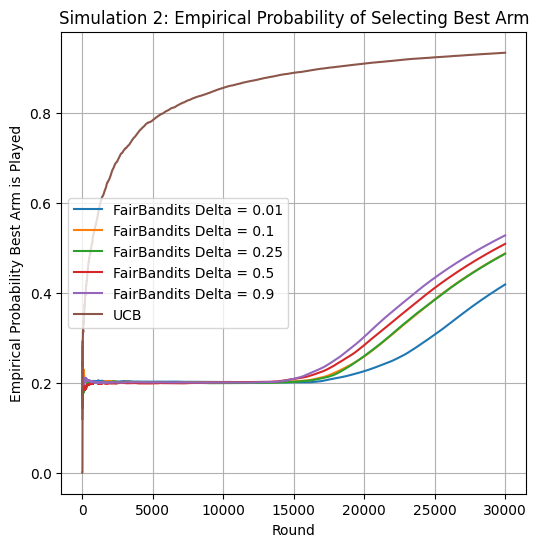

In [6]:
### Add mean probability of selecting best arm

import numpy as np
import matplotlib.pyplot as plt
import math

def plot_best_arm_probability(fair_bandit_class, ucb_bandit_class, success_probs, n_rounds, delta_values, n_simulations):
    plt.figure(figsize=(6, 6))
    best_arm = np.argmax(success_probs)

    # Plot for FairBandits with different delta values
    for delta in delta_values:
        best_arm_probabilities_all_simulations = np.zeros(n_rounds)
        
        for _ in range(n_simulations):
            fair_bandit = fair_bandit_class(len(success_probs), delta)
            best_arm_probabilities = np.zeros(n_rounds)
            
            for t in range(n_rounds):
                arm = fair_bandit.select_arm()
                reward = np.random.binomial(1, success_probs[arm])
                fair_bandit.update(arm, reward)
                best_arm_probabilities[t] = (arm == best_arm)
            
            # Accumulate the probabilities over all simulations
            best_arm_probabilities_all_simulations += best_arm_probabilities
        
        # Calculate the mean probability across all simulations
        mean_best_arm_probabilities = best_arm_probabilities_all_simulations / n_simulations
        
        # Plot cumulative empirical probability
        plt.plot(np.cumsum(mean_best_arm_probabilities) / (np.arange(n_rounds) + 1), label=f'FairBandits Delta = {delta}')
    
    # Plot for UCB1
    best_arm_probabilities_all_simulations_ucb1 = np.zeros(n_rounds)
    
    for _ in range(n_simulations):
        ucb_bandit = ucb_bandit_class(len(success_probs))
        best_arm_probabilities_ucb1 = np.zeros(n_rounds)
        
        for t in range(n_rounds):
            arm = ucb_bandit.select_arm()
            reward = np.random.binomial(1, success_probs[arm])
            ucb_bandit.update(arm, reward)
            best_arm_probabilities_ucb1[t] = (arm == best_arm)
        
        # Accumulate the probabilities over all simulations
        best_arm_probabilities_all_simulations_ucb1 += best_arm_probabilities_ucb1
    
    # Calculate the mean probability across all simulations for UCB1
    mean_best_arm_probabilities_ucb1 = best_arm_probabilities_all_simulations_ucb1 / n_simulations
    
    # Plot cumulative empirical probability for UCB1
    plt.plot(np.cumsum(mean_best_arm_probabilities_ucb1) / (np.arange(n_rounds) + 1), label='UCB')
    
    plt.xlabel('Round')
    plt.ylabel('Empirical Probability Best Arm is Played')
    plt.title('Simulation 2: Empirical Probability of Selecting Best Arm')
    plt.legend()
    plt.grid(True)
    plt.show()

#Parameters
n_arms = 5
n_rounds = 30000
success_probs = [0.3, 0.4, 0.5, 0.6, 0.7]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 25


# Plot the probability of selecting the best arm
plot_best_arm_probability(FairBandits, UCB1, success_probs, n_rounds, delta_values, n_simulations)

# Simulation 3: FairSleepingBandits 

Points of discussion - 



In [74]:
import math
import numpy as np
import matplotlib.pyplot as plt

class AUER:
    def __init__(self, n_arms, availability_probs):
        self.n_arms = n_arms
        self.availability_probs = availability_probs
        self.counts = [0 for _ in range(n_arms)]  # Number of times each arm was played
        self.values = [0.0 for _ in range(n_arms)]  # Sum of rewards for each arm
        self.awake_arms = set(range(n_arms))  # Set of currently awake arms

    def get_awake_arms(self):
        """ Determine which arms are awake based on availability probabilities. """
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.availability_probs[arm]}

    def select_arm(self, t):
        """ Select the arm with the highest AUER value among the awake arms. """
        for arm in self.awake_arms:
            if self.counts[arm] == 0:
                return arm  # Play each awake arm at least once

        ucb_values = [0.0 for _ in range(self.n_arms)]

        for arm in self.awake_arms:
            # Upper Confidence Bound (AUER)
            B = math.sqrt((8 * math.log(t)) / self.counts[arm])
            ucb_values[arm] = (self.values[arm] / self.counts[arm]) + B

        return max(self.awake_arms, key=lambda arm: ucb_values[arm])

    def update(self, chosen_arm, reward):
        """ Update counts and values for the chosen arm. """
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] += reward



In [75]:
class FairSleepingBandits:
    def __init__(self, n_arms, delta, sleep_prob):
        self.n_arms = n_arms
        self.delta = delta
        self.counts = [0 for i in range(n_arms)]
        self.values = [0.5 for i in range(n_arms)]
        self.upper_bounds = [1.0 for i in range(n_arms)]
        self.lower_bounds = [0.0 for i in range(n_arms)]
        self.sleep_probs = sleep_prob  # Probability list for each arm to sleep
        self.awake_arms = set(range(n_arms))
        #self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() > self.sleep_probs[arm]}

    
    def get_awake_arms(self):
        
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.sleep_probs[arm]}
    
    def select_arm(self):
        
        # Find the arm with the highest UCB out of all awake arms
        arm_max_ucb = max(self.awake_arms, key=lambda arm: self.upper_bounds[arm])
        
        # Find all chained arms to arm with max ucb
        chained_arms = self.find_chained_arms(arm_max_ucb)
        
        # Update active set to be the chained arms
        #self.active_set = chained_arms
        #self.active_set.add(arm_max_ucb)
        
        # Select an arm uniformly at random from the chained arms
        return np.random.choice(list(chained_arms))

    def find_chained_arms(self, start_arm):
        # Build the graph of linked arms
        
        G = nx.Graph()
        
            
        #for arms in self.active_set:
        #    G.add_node(arms)
        
        G.add_nodes_from(self.awake_arms)
            
        
        for arm1 in self.awake_arms:
            for arm2 in self.awake_arms:    
                arm1_interval = pd.Interval(self.lower_bounds[arm1], self.upper_bounds[arm1], closed='both')
                arm2_interval = pd.Interval(self.lower_bounds[arm2], self.upper_bounds[arm2], closed='both')

                if arm1 != arm2 and arm1_interval.overlaps(arm2_interval):
                    G.add_edge(arm1, arm2)
        
            
            
        # Use DFS to find chained arms to arm_max_ucb
        chained_arms = list(nx.dfs_preorder_nodes(G, source=start_arm))

        return set(chained_arms)
    
    

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        # Update the empirical mean reward
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
        
        # Update confidence intervals
        B = np.sqrt(np.log(((np.pi * (np.sum(self.counts) + 1))**2) / (3 * self.delta)) / (2 * n))
        self.upper_bounds[chosen_arm] = self.values[chosen_arm] + B
        self.lower_bounds[chosen_arm] = self.values[chosen_arm] - B




Note: cumulative regret is significantly lower than simulation 1 with all awake bandits. 

## Plots I want to use

## Simulation 3: 

Availability counts for FairSleepingBandits with delta=0.01: [14911, 17884, 21125, 24000, 26957]
Availability counts for FairSleepingBandits with delta=0.1: [15124, 18066, 21003, 23973, 27050]
Availability counts for FairSleepingBandits with delta=0.25: [15047, 17997, 20892, 24081, 27107]
Availability counts for FairSleepingBandits with delta=0.5: [14912, 18030, 20938, 23968, 27046]
Availability counts for FairSleepingBandits with delta=0.9: [14899, 18101, 20847, 24093, 26949]


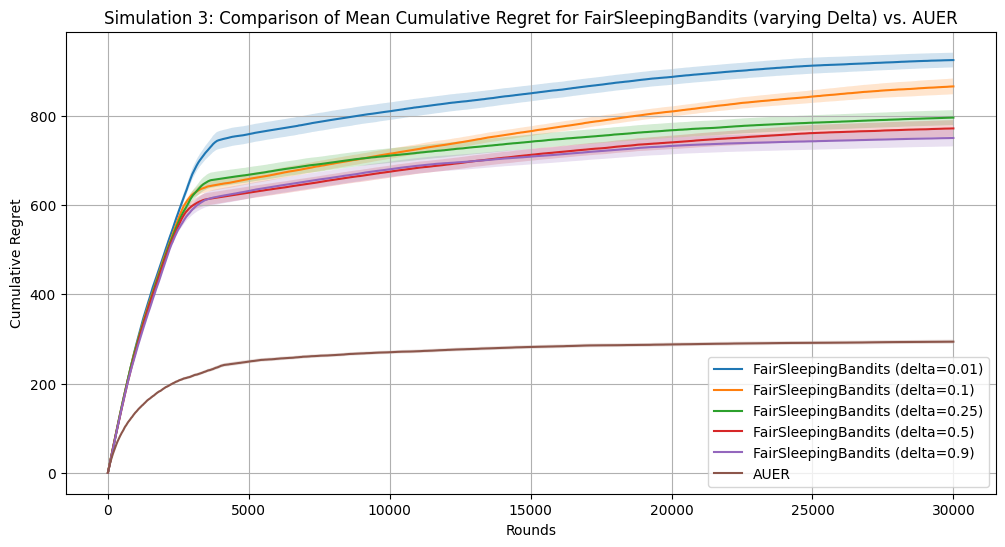

In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

class AUER:
    def __init__(self, n_arms, availability_probs):
        self.n_arms = n_arms
        self.availability_probs = availability_probs
        self.counts = [0 for _ in range(n_arms)]  # Number of times each arm was played
        self.values = [0.0 for _ in range(n_arms)]  # Sum of rewards for each arm
        self.awake_arms = set(range(n_arms))  # Set of currently awake arms
        self.availability_counts = [0 for _ in range(n_arms)]  # Track availability count for each arm

    def get_awake_arms(self):
        """ Determine which arms are awake based on availability probabilities. """
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.availability_probs[arm]}
        for arm in self.awake_arms:
            self.availability_counts[arm] += 1  # Increment availability count for each awake arm

    def select_arm(self, t):
        """ Select the arm with the highest AUER value among the awake arms. """
        for arm in self.awake_arms:
            if self.counts[arm] == 0:
                return arm  # Play each awake arm at least once

        ucb_values = [0.0 for _ in range(self.n_arms)]

        for arm in self.awake_arms:
            # Upper Confidence Bound (AUER)
            B = math.sqrt((8 * math.log(t)) / self.counts[arm])
            ucb_values[arm] = (self.values[arm] / self.counts[arm]) + B

        return max(self.awake_arms, key=lambda arm: ucb_values[arm])

    def update(self, chosen_arm, reward):
        """ Update counts and values for the chosen arm. """
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] += reward

class FairSleepingBandits:
    def __init__(self, n_arms, delta, sleep_prob):
        self.n_arms = n_arms
        self.delta = delta
        self.counts = [0 for i in range(n_arms)]
        self.values = [0.5 for i in range(n_arms)]
        self.upper_bounds = [1.0 for i in range(n_arms)]
        self.lower_bounds = [0.0 for i in range(n_arms)]
        self.sleep_probs = sleep_prob  # Probability list for each arm to sleep
        self.awake_arms = set(range(n_arms))
        self.availability_counts = [0 for i in range(n_arms)]  # Track the number of times each arm is available

    def get_awake_arms(self):
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.sleep_probs[arm]}
        for arm in self.awake_arms:
            self.availability_counts[arm] += 1  # Increment the availability count for each awake arm

    def select_arm(self):
        # Find the arm with the highest UCB out of all awake arms
        arm_max_ucb = max(self.awake_arms, key=lambda arm: self.upper_bounds[arm])
        
        # Find all chained arms to arm with max ucb
        chained_arms = self.find_chained_arms(arm_max_ucb)
        
        # Select an arm uniformly at random from the chained arms
        return np.random.choice(list(chained_arms))

    def find_chained_arms(self, start_arm):
        # Build the graph of linked arms
        G = nx.Graph()
        G.add_nodes_from(self.awake_arms)
        
        for arm1 in self.awake_arms:
            for arm2 in self.awake_arms:    
                arm1_interval = pd.Interval(self.lower_bounds[arm1], self.upper_bounds[arm1], closed='both')
                arm2_interval = pd.Interval(self.lower_bounds[arm2], self.upper_bounds[arm2], closed='both')

                if arm1 != arm2 and arm1_interval.overlaps(arm2_interval):
                    G.add_edge(arm1, arm2)
        
        # Use DFS to find chained arms to arm_max_ucb
        chained_arms = list(nx.dfs_preorder_nodes(G, source=start_arm))

        return set(chained_arms)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        # Update the empirical mean reward
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
        
        # Update confidence intervals
        B = np.sqrt(np.log(((np.pi * (np.sum(self.counts) + 1))**2) / (3 * self.delta)) / (2 * n))
        self.upper_bounds[chosen_arm] = self.values[chosen_arm] + B
        self.lower_bounds[chosen_arm] = self.values[chosen_arm] - B


# Simulation Parameters
n_arms = 5
n_rounds = 30000
availability_probs = [0.5, 0.6, 0.7, 0.8, 0.9] 
success_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 20

def calculate_current_regret(best_arm_mean, chosen_arm_mean):  
    return best_arm_mean - chosen_arm_mean

# Initialize storage for mean cumulative regrets and standard errors
all_mean_cumulative_regrets = {}
all_std_errors = {}

for delta in delta_values:
    cumulative_regrets_simulations = []

    for _ in range(n_simulations):
        fair_sleeping_bandit = FairSleepingBandits(n_arms, delta, availability_probs)
        cumulative_regret = 0
        cumulative_regret_sequence = []

        for t in range(n_rounds):
            fair_sleeping_bandit.get_awake_arms()
    
            if not fair_sleeping_bandit.awake_arms:
                continue  # If no arms are awake, skip this round
            
            arm = fair_sleeping_bandit.select_arm()
            reward = np.random.binomial(1, success_probs[arm])
            fair_sleeping_bandit.update(arm, reward)
            
            best_arm_mean = max([success_probs[arm] for arm in fair_sleeping_bandit.awake_arms])
            chosen_arm_mean = success_probs[arm]
            cumulative_regret += calculate_current_regret(best_arm_mean, chosen_arm_mean)
            cumulative_regret_sequence.append(cumulative_regret)
        
        # Ensure cumulative_regret_sequence has the correct length
        while len(cumulative_regret_sequence) < n_rounds:
            cumulative_regret_sequence.append(cumulative_regret_sequence[-1])
        
        cumulative_regrets_simulations.append(cumulative_regret_sequence)

    # Convert list of lists to a NumPy array for easier mean and std error calculation
    cumulative_regrets_simulations = np.array(cumulative_regrets_simulations)
    
    # Calculate mean cumulative regret and standard error across all simulations
    mean_cumulative_regret = np.mean(cumulative_regrets_simulations, axis=0)
    std_error = np.std(cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)
    
    all_mean_cumulative_regrets[delta] = mean_cumulative_regret
    all_std_errors[delta] = std_error

    # Print the availability counts
    print(f"Availability counts for FairSleepingBandits with delta={delta}: {fair_sleeping_bandit.availability_counts}")

# AUER Simulations
auer_cumulative_regrets_simulations = []

for _ in range(n_simulations):
    auer_bandit = AUER(n_arms, availability_probs)
    cumulative_regret = 0
    cumulative_regret_sequence = []

    for t in range(1, n_rounds + 1):
        auer_bandit.get_awake_arms()

        if not auer_bandit.awake_arms:
            continue  # If no arms are awake, skip this round

        arm = auer_bandit.select_arm(t)
        reward = np.random.binomial(1, success_probs[arm])
        auer_bandit.update(arm, reward)

        best_arm_mean = max([success_probs[arm] for arm in auer_bandit.awake_arms])
        chosen_arm_mean = success_probs[arm]
        cumulative_regret += calculate_current_regret(best_arm_mean, chosen_arm_mean)
        cumulative_regret_sequence.append(cumulative_regret)

    while len(cumulative_regret_sequence) < n_rounds:
        cumulative_regret_sequence.append(cumulative_regret_sequence[-1])

    auer_cumulative_regrets_simulations.append(cumulative_regret_sequence)

# Convert AUER results to NumPy array
auer_cumulative_regrets_simulations = np.array(auer_cumulative_regrets_simulations)
mean_auer_cumulative_regret = np.mean(auer_cumulative_regrets_simulations, axis=0)
auer_std_error = np.std(auer_cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot FairSleepingBandits for each delta
#colors = ['red', 'blue', 'green', 'purple', 'orange']
for i, delta in enumerate(delta_values):
    mean_cumulative_regret = all_mean_cumulative_regrets[delta]
    std_error = all_std_errors[delta]

    plt.plot(mean_cumulative_regret, label=f'FairSleepingBandits (delta={delta})')
    plt.fill_between(range(n_rounds), 
                     mean_cumulative_regret - std_error, 
                     mean_cumulative_regret + std_error, 
                     alpha=0.2)

# Plot AUER
plt.plot(mean_auer_cumulative_regret, label='AUER')
plt.fill_between(range(n_rounds), 
                 mean_auer_cumulative_regret - auer_std_error, 
                 mean_auer_cumulative_regret + auer_std_error, 
                 alpha=0.2)

plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Simulation 3: Comparison of Mean Cumulative Regret for FairSleepingBandits (varying Delta) vs. AUER')
plt.grid(True)
plt.legend()
plt.show()

In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

class AUER:
    def __init__(self, n_arms, availability_probs):
        self.n_arms = n_arms
        self.availability_probs = availability_probs
        self.counts = [0 for _ in range(n_arms)]  # Number of times each arm was played
        self.values = [0.0 for _ in range(n_arms)]  # Sum of rewards for each arm
        self.awake_arms = set(range(n_arms))  # Set of currently awake arms
        self.availability_counts = [0 for _ in range(n_arms)]  # Track availability count for each arm

    def get_awake_arms(self):
        """ Determine which arms are awake based on availability probabilities. """
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.availability_probs[arm]}
        for arm in self.awake_arms:
            self.availability_counts[arm] += 1  # Increment availability count for each awake arm

    def select_arm(self, t):
        """ Select the arm with the highest AUER value among the awake arms. """
        for arm in self.awake_arms:
            if self.counts[arm] == 0:
                return arm  # Play each awake arm at least once

        ucb_values = [0.0 for _ in range(self.n_arms)]

        for arm in self.awake_arms:
            # Upper Confidence Bound (AUER)
            B = math.sqrt((8 * math.log(t)) / self.counts[arm])
            ucb_values[arm] = (self.values[arm] / self.counts[arm]) + B

        return max(self.awake_arms, key=lambda arm: ucb_values[arm])

    def update(self, chosen_arm, reward):
        """ Update counts and values for the chosen arm. """
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] += reward

class FairSleepingBandits:
    def __init__(self, n_arms, delta, sleep_prob):
        self.n_arms = n_arms
        self.delta = delta
        self.counts = [0 for i in range(n_arms)]
        self.values = [0.5 for i in range(n_arms)]
        self.upper_bounds = [1.0 for i in range(n_arms)]
        self.lower_bounds = [0.0 for i in range(n_arms)]
        self.sleep_probs = sleep_prob  # Probability list for each arm to sleep
        self.awake_arms = set(range(n_arms))
        self.availability_counts = [0 for i in range(n_arms)]  # Track the number of times each arm is available

    def get_awake_arms(self):
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.sleep_probs[arm]}
        for arm in self.awake_arms:
            self.availability_counts[arm] += 1  # Increment the availability count for each awake arm

    def select_arm(self):
        # Find the arm with the highest UCB out of all awake arms
        arm_max_ucb = max(self.awake_arms, key=lambda arm: self.upper_bounds[arm])
        
        # Find all chained arms to arm with max ucb
        chained_arms = self.find_chained_arms(arm_max_ucb)
        
        # Select an arm uniformly at random from the chained arms
        return np.random.choice(list(chained_arms))

    def find_chained_arms(self, start_arm):
        # Build the graph of linked arms
        G = nx.Graph()
        G.add_nodes_from(self.awake_arms)
        
        for arm1 in self.awake_arms:
            for arm2 in self.awake_arms:    
                arm1_interval = pd.Interval(self.lower_bounds[arm1], self.upper_bounds[arm1], closed='both')
                arm2_interval = pd.Interval(self.lower_bounds[arm2], self.upper_bounds[arm2], closed='both')

                if arm1 != arm2 and arm1_interval.overlaps(arm2_interval):
                    G.add_edge(arm1, arm2)
        
        # Use DFS to find chained arms to arm_max_ucb
        chained_arms = list(nx.dfs_preorder_nodes(G, source=start_arm))

        return set(chained_arms)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        # Update the empirical mean reward
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
        
        # Update confidence intervals
        B = np.sqrt(np.log(((np.pi * (np.sum(self.counts) + 1))**2) / (3 * self.delta)) / (2 * n))
        self.upper_bounds[chosen_arm] = self.values[chosen_arm] + B
        self.lower_bounds[chosen_arm] = self.values[chosen_arm] - B


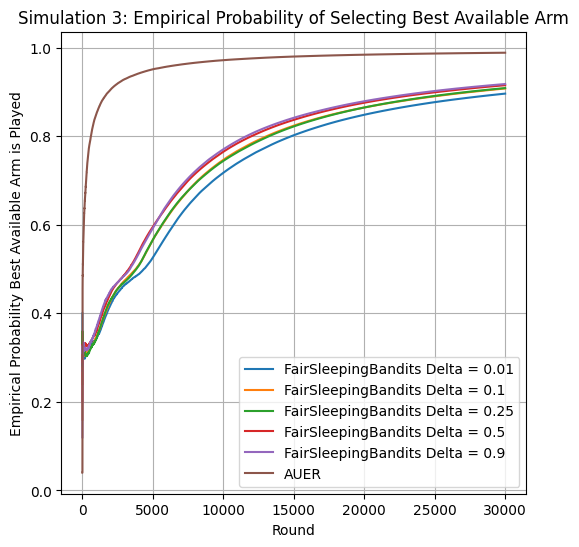

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import math

def get_best_available_arm(success_probs, awake_arms):
    """Determine the best available arm among the awake arms."""
    if not awake_arms:  # Check if awake_arms is empty
        return None
    awake_success_probs = [success_probs[arm] for arm in awake_arms]
    best_awake_arm = list(awake_arms)[np.argmax(awake_success_probs)]
    return best_awake_arm

def plot_best_available_arm_probability(fair_sleeping_bandit_class, auer_bandit_class, success_probs, n_rounds, delta_values, n_simulations, availability_probs):
    plt.figure(figsize=(6, 6))
    
    for delta in delta_values:
        best_awake_arm_probabilities_all_simulations = np.zeros(n_rounds)
        
        for _ in range(n_simulations):
            fair_bandit = fair_sleeping_bandit_class(len(success_probs), delta, availability_probs)
            best_awake_arm_probabilities = np.zeros(n_rounds)
            
            for t in range(n_rounds):
                fair_bandit.get_awake_arms()
                awake_arms = fair_bandit.awake_arms
                best_awake_arm = get_best_available_arm(success_probs, awake_arms)
                if best_awake_arm is not None:  # Proceed only if there are awake arms
                    arm = fair_bandit.select_arm()
                    reward = np.random.binomial(1, success_probs[arm])
                    fair_bandit.update(arm, reward)
                    best_awake_arm_probabilities[t] = (arm == best_awake_arm)
            
            best_awake_arm_probabilities_all_simulations += best_awake_arm_probabilities
        
        mean_best_awake_arm_probabilities = best_awake_arm_probabilities_all_simulations / n_simulations
        plt.plot(np.cumsum(mean_best_awake_arm_probabilities) / (np.arange(n_rounds) + 1), label=f'FairSleepingBandits Delta = {delta}')
    
    best_awake_arm_probabilities_all_simulations_auer = np.zeros(n_rounds)
    
    for _ in range(n_simulations):
        auer_bandit = auer_bandit_class(len(success_probs), availability_probs)
        best_awake_arm_probabilities_auer = np.zeros(n_rounds)
        
        for t in range(n_rounds):
            auer_bandit.get_awake_arms()
            awake_arms = auer_bandit.awake_arms
            best_awake_arm = get_best_available_arm(success_probs, awake_arms)
            if best_awake_arm is not None:  # Proceed only if there are awake arms
                arm = auer_bandit.select_arm(t + 1)
                reward = np.random.binomial(1, success_probs[arm])
                auer_bandit.update(arm, reward)
                best_awake_arm_probabilities_auer[t] = (arm == best_awake_arm)
        
        best_awake_arm_probabilities_all_simulations_auer += best_awake_arm_probabilities_auer
    
    mean_best_awake_arm_probabilities_auer = best_awake_arm_probabilities_all_simulations_auer / n_simulations
    plt.plot(np.cumsum(mean_best_awake_arm_probabilities_auer) / (np.arange(n_rounds) + 1), label='AUER')
    
    plt.xlabel('Round')
    plt.ylabel('Empirical Probability Best Available Arm is Played')
    plt.title('Simulation 3: Empirical Probability of Selecting Best Available Arm')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulation Parameters
n_arms = 5
n_rounds = 30000
availability_probs = [0.9, 0.8, 0.7, 0.6, 0.5] 
success_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 25

# Plot the probability of selecting the best available arm
plot_best_available_arm_probability(FairSleepingBandits, AUER, success_probs, n_rounds, delta_values, n_simulations, availability_probs)



## Simulation 4: Decreassing availability probabilities

availability_probs = [0.9, 0.8, 0.7, 0.6, 0.5] 


Availability counts for FairSleepingBandits with delta=0.01: [27003, 23994, 20987, 17827, 14982]
Availability counts for FairSleepingBandits with delta=0.1: [26999, 24157, 21159, 17935, 15004]
Availability counts for FairSleepingBandits with delta=0.25: [26976, 23978, 21011, 18023, 14973]
Availability counts for FairSleepingBandits with delta=0.5: [26937, 23973, 21026, 18039, 14977]
Availability counts for FairSleepingBandits with delta=0.9: [26866, 24084, 20963, 17994, 14929]


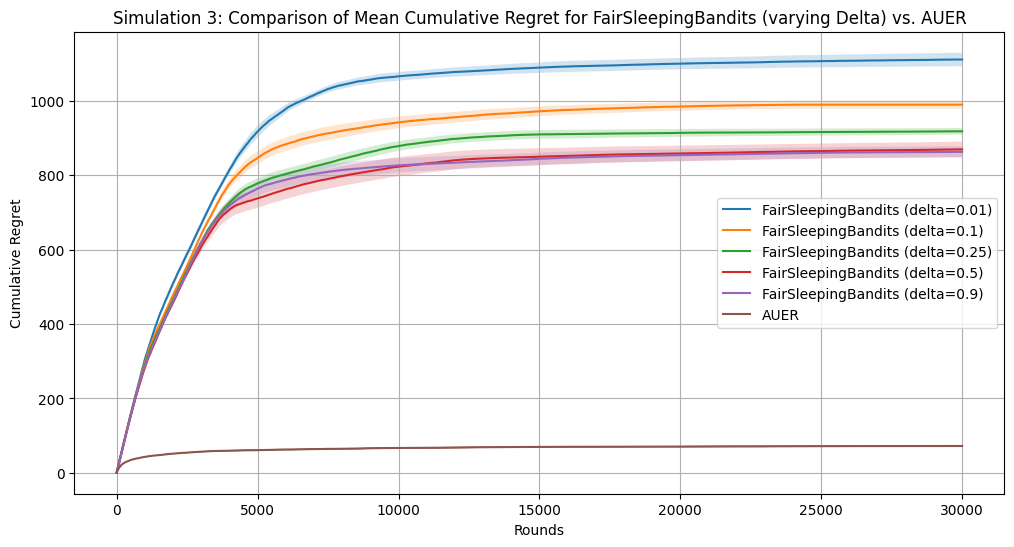

In [73]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

class AUER:
    def __init__(self, n_arms, availability_probs):
        self.n_arms = n_arms
        self.availability_probs = availability_probs
        self.counts = [0 for _ in range(n_arms)]  # Number of times each arm was played
        self.values = [0.0 for _ in range(n_arms)]  # Sum of rewards for each arm
        self.awake_arms = set(range(n_arms))  # Set of currently awake arms
        self.availability_counts = [0 for _ in range(n_arms)]  # Track availability count for each arm

    def get_awake_arms(self):
        """ Determine which arms are awake based on availability probabilities. """
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.availability_probs[arm]}
        for arm in self.awake_arms:
            self.availability_counts[arm] += 1  # Increment availability count for each awake arm

    def select_arm(self, t):
        """ Select the arm with the highest AUER value among the awake arms. """
        for arm in self.awake_arms:
            if self.counts[arm] == 0:
                return arm  # Play each awake arm at least once

        ucb_values = [0.0 for _ in range(self.n_arms)]

        for arm in self.awake_arms:
            # Upper Confidence Bound (AUER)
            B = math.sqrt((8 * math.log(t)) / self.counts[arm])
            ucb_values[arm] = (self.values[arm] / self.counts[arm]) + B

        return max(self.awake_arms, key=lambda arm: ucb_values[arm])

    def update(self, chosen_arm, reward):
        """ Update counts and values for the chosen arm. """
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] += reward

class FairSleepingBandits:
    def __init__(self, n_arms, delta, sleep_prob):
        self.n_arms = n_arms
        self.delta = delta
        self.counts = [0 for i in range(n_arms)]
        self.values = [0.5 for i in range(n_arms)]
        self.upper_bounds = [1.0 for i in range(n_arms)]
        self.lower_bounds = [0.0 for i in range(n_arms)]
        self.sleep_probs = sleep_prob  # Probability list for each arm to sleep
        self.awake_arms = set(range(n_arms))
        self.availability_counts = [0 for i in range(n_arms)]  # Track the number of times each arm is available

    def get_awake_arms(self):
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.sleep_probs[arm]}
        for arm in self.awake_arms:
            self.availability_counts[arm] += 1  # Increment the availability count for each awake arm

    def select_arm(self):
        # Find the arm with the highest UCB out of all awake arms
        arm_max_ucb = max(self.awake_arms, key=lambda arm: self.upper_bounds[arm])
        
        # Find all chained arms to arm with max ucb
        chained_arms = self.find_chained_arms(arm_max_ucb)
        
        # Select an arm uniformly at random from the chained arms
        return np.random.choice(list(chained_arms))

    def find_chained_arms(self, start_arm):
        # Build the graph of linked arms
        G = nx.Graph()
        G.add_nodes_from(self.awake_arms)
        
        for arm1 in self.awake_arms:
            for arm2 in self.awake_arms:    
                arm1_interval = pd.Interval(self.lower_bounds[arm1], self.upper_bounds[arm1], closed='both')
                arm2_interval = pd.Interval(self.lower_bounds[arm2], self.upper_bounds[arm2], closed='both')

                if arm1 != arm2 and arm1_interval.overlaps(arm2_interval):
                    G.add_edge(arm1, arm2)
        
        # Use DFS to find chained arms to arm_max_ucb
        chained_arms = list(nx.dfs_preorder_nodes(G, source=start_arm))

        return set(chained_arms)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        # Update the empirical mean reward
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
        
        # Update confidence intervals
        B = np.sqrt(np.log(((np.pi * (np.sum(self.counts) + 1))**2) / (3 * self.delta)) / (2 * n))
        self.upper_bounds[chosen_arm] = self.values[chosen_arm] + B
        self.lower_bounds[chosen_arm] = self.values[chosen_arm] - B


# Simulation Parameters
n_arms = 5
n_rounds = 30000
availability_probs = [0.9, 0.8, 0.7, 0.6, 0.5] 
success_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
n_simulations = 10

def calculate_current_regret(best_arm_mean, chosen_arm_mean):  
    return best_arm_mean - chosen_arm_mean

# Initialize storage for mean cumulative regrets and standard errors
all_mean_cumulative_regrets = {}
all_std_errors = {}

for delta in delta_values:
    cumulative_regrets_simulations = []

    for _ in range(n_simulations):
        fair_sleeping_bandit = FairSleepingBandits(n_arms, delta, availability_probs)
        cumulative_regret = 0
        cumulative_regret_sequence = []

        for t in range(n_rounds):
            fair_sleeping_bandit.get_awake_arms()
    
            if not fair_sleeping_bandit.awake_arms:
                continue  # If no arms are awake, skip this round
            
            arm = fair_sleeping_bandit.select_arm()
            reward = np.random.binomial(1, success_probs[arm])
            fair_sleeping_bandit.update(arm, reward)
            
            best_arm_mean = max([success_probs[arm] for arm in fair_sleeping_bandit.awake_arms])
            chosen_arm_mean = success_probs[arm]
            cumulative_regret += calculate_current_regret(best_arm_mean, chosen_arm_mean)
            cumulative_regret_sequence.append(cumulative_regret)
        
        # Ensure cumulative_regret_sequence has the correct length
        while len(cumulative_regret_sequence) < n_rounds:
            cumulative_regret_sequence.append(cumulative_regret_sequence[-1])
        
        cumulative_regrets_simulations.append(cumulative_regret_sequence)

    # Convert list of lists to a NumPy array for easier mean and std error calculation
    cumulative_regrets_simulations = np.array(cumulative_regrets_simulations)
    
    # Calculate mean cumulative regret and standard error across all simulations
    mean_cumulative_regret = np.mean(cumulative_regrets_simulations, axis=0)
    std_error = np.std(cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)
    
    all_mean_cumulative_regrets[delta] = mean_cumulative_regret
    all_std_errors[delta] = std_error

    # Print the availability counts
    print(f"Availability counts for FairSleepingBandits with delta={delta}: {fair_sleeping_bandit.availability_counts}")

# AUER Simulations
auer_cumulative_regrets_simulations = []

for _ in range(n_simulations):
    auer_bandit = AUER(n_arms, availability_probs)
    cumulative_regret = 0
    cumulative_regret_sequence = []

    for t in range(1, n_rounds + 1):
        auer_bandit.get_awake_arms()

        if not auer_bandit.awake_arms:
            continue  # If no arms are awake, skip this round

        arm = auer_bandit.select_arm(t)
        reward = np.random.binomial(1, success_probs[arm])
        auer_bandit.update(arm, reward)

        best_arm_mean = max([success_probs[arm] for arm in auer_bandit.awake_arms])
        chosen_arm_mean = success_probs[arm]
        cumulative_regret += calculate_current_regret(best_arm_mean, chosen_arm_mean)
        cumulative_regret_sequence.append(cumulative_regret)

    while len(cumulative_regret_sequence) < n_rounds:
        cumulative_regret_sequence.append(cumulative_regret_sequence[-1])

    auer_cumulative_regrets_simulations.append(cumulative_regret_sequence)

# Convert AUER results to NumPy array
auer_cumulative_regrets_simulations = np.array(auer_cumulative_regrets_simulations)
mean_auer_cumulative_regret = np.mean(auer_cumulative_regrets_simulations, axis=0)
auer_std_error = np.std(auer_cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot FairSleepingBandits for each delta

for i, delta in enumerate(delta_values):
    mean_cumulative_regret = all_mean_cumulative_regrets[delta]
    std_error = all_std_errors[delta]

    plt.plot(mean_cumulative_regret, label=f'FairSleepingBandits (delta={delta})')
    plt.fill_between(range(n_rounds), 
                     mean_cumulative_regret - std_error, 
                     mean_cumulative_regret + std_error, 
                     alpha=0.2)

# Plot AUER
plt.plot(mean_auer_cumulative_regret, label='AUER')
plt.fill_between(range(n_rounds), 
                 mean_auer_cumulative_regret - auer_std_error, 
                 mean_auer_cumulative_regret + auer_std_error, 
                 )


plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Simulation 3: Comparison of Mean Cumulative Regret for FairSleepingBandits (varying Delta) vs. AUER')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
### Add probability of selecting best arm



# FairCombSleepingBandits - Simulation 5

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt

class LLRS:
    def __init__(self, n_arms, m, mu_true, p, R_star):
        self.n_arms = n_arms
        self.m = m
        self.mu_true = mu_true  # True mean rewards of each arm
        self.p = p  # Probability that each arm is available (awake)
        self.R_star = R_star  # Optimal reward for fairness regret calculation

        self.h = np.zeros(n_arms)  # Number of times each arm is played
        self.total_rewards = np.zeros(n_arms)  # Total rewards obtained from each arm
        self.mu_hat = np.zeros(n_arms)  # Empirical mean rewards of each arm
        self.UCB = np.ones(n_arms)  # UCB values for each arm
        self.T = 0  # Total number of rounds
        self.regret = 0  # Cumulative regret
        self.fair_regret = 0  # Cumulative fairness regret
        self.cumulative_mean_reward = 0  # Cumulative mean reward

        # Lists to track the cumulative and average regrets over time
        self.cumulative_regrets = []
        self.average_regrets = []
        self.cumulative_fair_regrets = []
        self.average_fair_regrets = []

    def get_awake_arms(self):
        """Determine which arms are awake based on their availability probabilities."""
        return {arm for arm in range(self.n_arms) if np.random.rand() < self.p[arm]}

    def update_UCB(self):
        """Update UCB values based on current empirical mean rewards and number of plays."""
        for i in range(self.n_arms):
            if self.h[i] > 0:
                self.UCB[i] = min(self.mu_hat[i] + np.sqrt((3 * np.log(self.T)) / (2 * self.h[i])), 1)
            else:
                self.UCB[i] = 1  # Ensure unplayed arms have a high UCB to be explored

    def select_super_arm(self, available_arms):
        """Select the super arm (a subset of available arms) that maximizes the sum of UCB values."""
        super_arm = set()
        m_star = min(self.m, len(available_arms))  # Ensure we don't select more than m arms
        
        for _ in range(m_star):
            best_arm = max(available_arms - super_arm, key=lambda i: self.UCB[i])
            super_arm.add(best_arm)
        
        return super_arm

    def play_arms(self, super_arm):
        """Simulate playing the selected arms and obtain rewards."""
        rewards = {i: np.random.binomial(1, self.mu_true[i]) for i in super_arm}
        return rewards

    def get_optimal_reward(self, available_arms):
        """Calculate the optimal reward by selecting the top m arms from the available arms."""
        best_arms = sorted([self.mu_true[i] for i in available_arms], reverse=True)[:self.m]
        return sum(best_arms)

    def run(self, rounds):
        """Run the LLRS algorithm for a specified number of rounds."""
        for t in range(1, rounds + 1):
            self.T = t

            available_arms = self.get_awake_arms()

            self.update_UCB()

            super_arm = self.select_super_arm(available_arms)
            
            if super_arm:
                rewards = self.play_arms(super_arm)
                
                for i in super_arm:
                    self.total_rewards[i] += rewards[i]
                    self.h[i] += 1
                    self.mu_hat[i] = self.total_rewards[i] / self.h[i]
                
                optimal_reward = self.get_optimal_reward(available_arms)
                obtained_mean_reward = sum(self.mu_true[i] for i in super_arm)
                self.cumulative_mean_reward += obtained_mean_reward
                self.regret += (optimal_reward - obtained_mean_reward)
                self.fair_regret = (t * self.R_star) - self.cumulative_mean_reward

            # Record cumulative and average regrets
            self.cumulative_regrets.append(self.regret)
            self.cumulative_fair_regrets.append(self.fair_regret)
            avg_regret = self.regret / t
            avg_fair_regret = self.fair_regret / t
            self.average_regrets.append(avg_regret)
            self.average_fair_regrets.append(avg_fair_regret)

        return self.cumulative_regrets, self.average_regrets, self.cumulative_fair_regrets, self.average_fair_regrets




In [11]:
class FairCombSleepingBandits:
    def __init__(self, n_arms, delta, sleep_prob, m, mu_true):
        self.n_arms = n_arms
        self.delta = delta
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.5 for _ in range(n_arms)]
        self.upper_bounds = [1.0 for _ in range(n_arms)]
        self.lower_bounds = [0.0 for _ in range(n_arms)]
        self.sleep_probs = sleep_prob  # Probability list for each arm to sleep
        self.awake_arms = set(range(n_arms))
        self.m = m  # Maximum number of arms to play each round
        self.mu_true = mu_true  # True reward means for each arm
    
    def get_awake_arms(self):
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.sleep_probs[arm]}
    
    def select_arms(self):
        # Determine the number of arms that can be played in this round
        m_star = min(self.m, len(self.awake_arms))
        P_t = set()  # Selected arms set
        M_t = self.awake_arms.copy()  # Remaining arms to consider
        
        while len(P_t) < m_star and M_t:
            # Select the arm with the highest UCB from the remaining set
            i_t_star = max(M_t, key=lambda arm: self.upper_bounds[arm])
            
            # Find the set of arms chained to i_t_star
            S_t = self.find_chained_arms(i_t_star, M_t)
            
            if len(P_t.union(S_t)) <= m_star:
                P_t = P_t.union(S_t)
                M_t -= S_t
            else:
                q_t = m_star - len(P_t)
                Q_t = set(np.random.choice(list(S_t), q_t, replace=False))
                P_t = P_t.union(Q_t)
        
        return list(P_t)
    
    def find_chained_arms(self, start_arm, available_arms):
        # Build the graph of linked arms
        G = nx.Graph()
        G.add_nodes_from(available_arms)
        
        for arm1 in available_arms:
            for arm2 in available_arms:
                arm1_interval = pd.Interval(self.lower_bounds[arm1], self.upper_bounds[arm1], closed='both')
                arm2_interval = pd.Interval(self.lower_bounds[arm2], self.upper_bounds[arm2], closed='both')
                
                if arm1 != arm2 and arm1_interval.overlaps(arm2_interval):
                    G.add_edge(arm1, arm2)
        
        # Use DFS to find chained arms to start_arm
        chained_arms = list(nx.dfs_preorder_nodes(G, source=start_arm))
        return set(chained_arms)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        # Update the empirical mean reward
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
        
        # Update confidence intervals
        B = np.sqrt(np.log(((np.pi * (np.sum(self.counts) + 1))**2) / (3 * self.delta)) / (2 * n))
        self.upper_bounds[chosen_arm] = self.values[chosen_arm] + B
        self.lower_bounds[chosen_arm] = self.values[chosen_arm] - B

    def get_optimal_reward(self, available_arms):
        # Calculate the maximum possible reward from the available arms in this round
        best_arms = sorted([self.mu_true[i] for i in available_arms], reverse=True)[:self.m]
        return sum(best_arms)

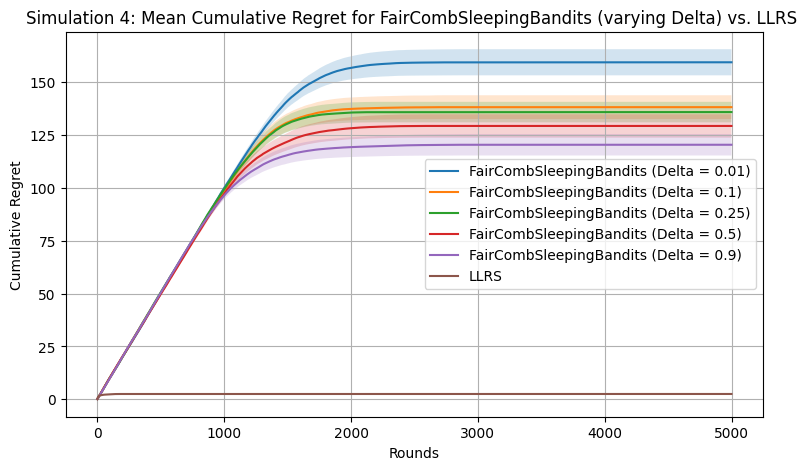

In [91]:
# Simulation parameters
n_arms = 3
n_rounds = 5000
success_probs = [0.3, 0.5, 0.7]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
awake_probs = [0.9, 0.8, 0.7]
m = 2  # Maximum number of arms to play each round
n_simulations = 100 # Number of simulations

# Initialize data storage
all_mean_cumulative_regrets = {}
all_std_errors = {}

# Run the simulation for each delta value
for delta in delta_values:
    cumulative_regrets_simulations = []
    
    for _ in range(n_simulations):
        fair_comb_bandit = FairCombSleepingBandits(n_arms, delta, awake_probs, m, success_probs)
        cumulative_regret = 0
        cumulative_regret_sequence = []

        for t in range(n_rounds):
            fair_comb_bandit.get_awake_arms()
            
            if not fair_comb_bandit.awake_arms:
                if cumulative_regret_sequence:
                    cumulative_regret_sequence.append(cumulative_regret_sequence[-1])
                else:
                    cumulative_regret_sequence.append(0)
                continue
            
            selected_arms = fair_comb_bandit.select_arms()
            rewards = [np.random.binomial(1, success_probs[arm]) for arm in selected_arms]
            
            for i, arm in enumerate(selected_arms):
                fair_comb_bandit.update(arm, rewards[i])
            
            optimal_reward = fair_comb_bandit.get_optimal_reward(fair_comb_bandit.awake_arms)
            obtained_reward = sum(success_probs[arm] for arm in selected_arms)
            cumulative_regret += (optimal_reward - obtained_reward)
            cumulative_regret_sequence.append(cumulative_regret)
        
        # Ensure the sequence has the correct length
        while len(cumulative_regret_sequence) < n_rounds:
            cumulative_regret_sequence.append(cumulative_regret_sequence[-1])
        
        cumulative_regrets_simulations.append(cumulative_regret_sequence)
    
    # Convert to NumPy array for easier calculations
    cumulative_regrets_simulations = np.array(cumulative_regrets_simulations)
    
    # Calculate the mean and standard error
    mean_cumulative_regret = np.mean(cumulative_regrets_simulations, axis=0)
    std_error = np.std(cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)
    
    all_mean_cumulative_regrets[delta] = mean_cumulative_regret
    all_std_errors[delta] = std_error

# Initialize data storage for LLRS
llrs_cumulative_regrets_simulations = []

# Define the success probabilities and awake probabilities for LLRS
mu_true = success_probs  # Reusing success_probs for LLRS's true reward probabilities
p = awake_probs  # Reusing awake_probs for LLRS's arm awake probabilities


# Run the LLRS simulation
for _ in range(n_simulations):
    llrs = LLRS(n_arms,  m, success_probs, awake_probs, R_star)
    cumulative_regrets, average_regrets, cumulative_fair_regrets, average_fair_regrets = llrs.run(n_rounds)

    llrs_cumulative_regrets_simulations.append(cumulative_regrets)

# Calculate the mean and standard error for LLRS
llrs_cumulative_regrets_simulations = np.array(llrs_cumulative_regrets_simulations)
llrs_mean_cumulative_regret = np.mean(llrs_cumulative_regrets_simulations, axis=0)
llrs_std_error = np.std(llrs_cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)

# Combined Plot with FairCombSleepingBandits and LLRS
plt.figure(figsize=(9, 5))

# Plot FairCombSleepingBandits results
for delta in delta_values:
    mean_regret = all_mean_cumulative_regrets[delta]
    std_error = all_std_errors[delta]
    
    plt.plot(mean_regret, label=f'FairCombSleepingBandits (Delta = {delta})')
    plt.fill_between(range(len(mean_regret)), mean_regret - 2 * std_error, mean_regret + 2 * std_error, alpha=0.2)

# Plot LLRS results
plt.plot(llrs_mean_cumulative_regret, label='LLRS')
plt.fill_between(range(len(llrs_mean_cumulative_regret)), 
                 llrs_mean_cumulative_regret - 2 * llrs_std_error, 
                 llrs_mean_cumulative_regret + 2 * llrs_std_error, 
                 alpha=0.2)

plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Simulation 4: Mean Cumulative Regret for FairCombSleepingBandits (varying Delta) vs. LLRS ')
plt.legend()
plt.grid(True)
plt.show()




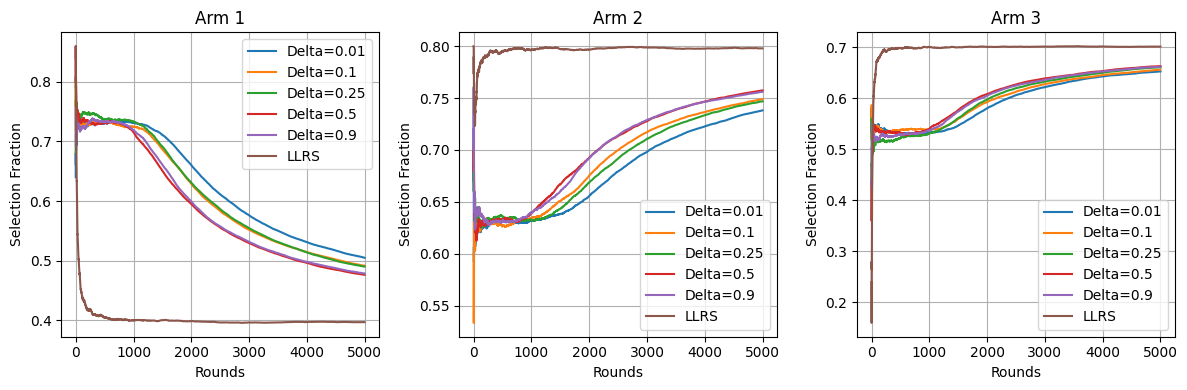

In [96]:
import numpy as np
import matplotlib.pyplot as plt

class LLRS:
    def __init__(self, n_arms, m, mu_true, p, R_star):
        self.n_arms = n_arms
        self.m = m
        self.mu_true = mu_true  # True mean rewards of each arm
        self.p = p  # Probability that each arm is available (awake)
        self.R_star = R_star  # Optimal reward for fairness regret calculation

        self.h = np.zeros(n_arms)  # Number of times each arm is played
        self.total_rewards = np.zeros(n_arms)  # Total rewards obtained from each arm
        self.mu_hat = np.zeros(n_arms)  # Empirical mean rewards of each arm
        self.UCB = np.ones(n_arms)  # UCB values for each arm
        self.T = 0  # Total number of rounds
        self.regret = 0  # Cumulative regret
        self.fair_regret = 0  # Cumulative fairness regret
        self.cumulative_mean_reward = 0  # Cumulative mean reward

    def get_awake_arms(self):
        """Determine which arms are awake based on their availability probabilities."""
        return {arm for arm in range(self.n_arms) if np.random.rand() < self.p[arm]}

    def update_UCB(self):
        """Update UCB values based on current empirical mean rewards and number of plays."""
        for i in range(self.n_arms):
            if self.h[i] > 0:
                self.UCB[i] = min(self.mu_hat[i] + np.sqrt((3 * np.log(self.T)) / (2 * self.h[i])), 1)
            else:
                self.UCB[i] = 1  # Ensure unplayed arms have a high UCB to be explored

    def select_super_arm(self, available_arms):
        """Select the super arm (a subset of available arms) that maximizes the sum of UCB values."""
        super_arm = set()
        m_star = min(self.m, len(available_arms))  # Ensure we don't select more than m arms
        
        for _ in range(m_star):
            best_arm = max(available_arms - super_arm, key=lambda i: self.UCB[i])
            super_arm.add(best_arm)
        
        return super_arm

    def play_arms(self, super_arm):
        """Simulate playing the selected arms and obtain rewards."""
        rewards = {i: np.random.binomial(1, self.mu_true[i]) for i in super_arm}
        return rewards

    def get_optimal_reward(self, available_arms):
        """Calculate the optimal reward by selecting the top m arms from the available arms."""
        best_arms = sorted([self.mu_true[i] for i in available_arms], reverse=True)[:self.m]
        return sum(best_arms)

    def run(self, rounds):
        """Run the LLRS algorithm for a specified number of rounds."""
        selection_count = np.zeros((self.n_arms, rounds))
        
        for t in range(1, rounds + 1):
            self.T = t
            available_arms = self.get_awake_arms()
            self.update_UCB()
            super_arm = self.select_super_arm(available_arms)
            
            if super_arm:
                rewards = self.play_arms(super_arm)
                for i in super_arm:
                    self.total_rewards[i] += rewards[i]
                    self.h[i] += 1
                    self.mu_hat[i] = self.total_rewards[i] / self.h[i]
                    selection_count[i, t-1] += 1

            optimal_reward = self.get_optimal_reward(available_arms)
            obtained_mean_reward = sum(self.mu_true[i] for i in super_arm)
            self.cumulative_mean_reward += obtained_mean_reward
            self.regret += (optimal_reward - obtained_mean_reward)
            self.fair_regret = (t * self.R_star) - self.cumulative_mean_reward

        selection_fraction = np.cumsum(selection_count, axis=1) / np.arange(1, rounds + 1)
        return selection_fraction


class FairCombSleepingBandits:
    def __init__(self, n_arms, delta, sleep_prob, m, mu_true):
        self.n_arms = n_arms
        self.delta = delta
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.5 for _ in range(n_arms)]
        self.upper_bounds = [1.0 for _ in range(n_arms)]
        self.lower_bounds = [0.0 for _ in range(n_arms)]
        self.sleep_probs = sleep_prob  # Probability list for each arm to sleep
        self.awake_arms = set(range(n_arms))
        self.m = m  # Maximum number of arms to play each round
        self.mu_true = mu_true  # True reward means for each arm
    
    def get_awake_arms(self):
        self.awake_arms = {arm for arm in range(self.n_arms) if np.random.rand() < self.sleep_probs[arm]}
    
    def select_arms(self):
        m_star = min(self.m, len(self.awake_arms))
        P_t = set()  # Selected arms set
        M_t = self.awake_arms.copy()  # Remaining arms to consider
        
        while len(P_t) < m_star and M_t:
            i_t_star = max(M_t, key=lambda arm: self.upper_bounds[arm])
            S_t = self.find_chained_arms(i_t_star, M_t)
            
            if len(P_t.union(S_t)) <= m_star:
                P_t = P_t.union(S_t)
                M_t -= S_t
            else:
                q_t = m_star - len(P_t)
                Q_t = set(np.random.choice(list(S_t), q_t, replace=False))
                P_t = P_t.union(Q_t)
        
        return list(P_t)
    
    def find_chained_arms(self, start_arm, available_arms):
        import networkx as nx
        import pandas as pd
        
        G = nx.Graph()
        G.add_nodes_from(available_arms)
        
        for arm1 in available_arms:
            for arm2 in available_arms:
                arm1_interval = pd.Interval(self.lower_bounds[arm1], self.upper_bounds[arm1], closed='both')
                arm2_interval = pd.Interval(self.lower_bounds[arm2], self.upper_bounds[arm2], closed='both')
                
                if arm1 != arm2 and arm1_interval.overlaps(arm2_interval):
                    G.add_edge(arm1, arm2)
        
        chained_arms = list(nx.dfs_preorder_nodes(G, source=start_arm))
        return set(chained_arms)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
        
        B = np.sqrt(np.log(((np.pi * (np.sum(self.counts) + 1))**2) / (3 * self.delta)) / (2 * n))
        self.upper_bounds[chosen_arm] = self.values[chosen_arm] + B
        self.lower_bounds[chosen_arm] = self.values[chosen_arm] - B

    def get_optimal_reward(self, available_arms):
        best_arms = sorted([self.mu_true[i] for i in available_arms], reverse=True)[:self.m]
        return sum(best_arms)

    def run(self, n_rounds):
        selection_count = np.zeros((self.n_arms, n_rounds))

        for t in range(n_rounds):
            self.get_awake_arms()
            
            if not self.awake_arms:
                continue
            
            selected_arms = self.select_arms()
            rewards = [np.random.binomial(1, self.mu_true[arm]) for arm in selected_arms]
            
            for i, arm in enumerate(selected_arms):
                self.update(arm, rewards[i])
                selection_count[arm, t] += 1
        
        selection_fraction = np.cumsum(selection_count, axis=1) / np.arange(1, n_rounds + 1)
        return selection_fraction


# Simulation parameters
n_arms = 3
n_rounds = 5000
success_probs = [0.3, 0.5, 0.7]
delta_values = [0.01, 0.1, 0.25, 0.5, 0.9]
awake_probs = [0.9, 0.8, 0.7]
m = 2
n_simulations = 25


# Storage for selection fractions
all_selection_fractions = {delta: np.zeros((n_arms, n_rounds)) for delta in delta_values}
llrs_selection_fractions = np.zeros((n_arms, n_rounds))

# Run the simulation for each delta value in FairCombSleepingBandits
for delta in delta_values:
    selection_fractions_simulations = []

    for _ in range(n_simulations):
        fair_comb_bandit = FairCombSleepingBandits(n_arms, delta, awake_probs, m, success_probs)
        selection_fractions = fair_comb_bandit.run(n_rounds)
        selection_fractions_simulations.append(selection_fractions)
    
    # Convert to NumPy array for easier calculations
    selection_fractions_simulations = np.array(selection_fractions_simulations)
    
    # Calculate the mean selection fraction
    mean_selection_fraction = np.mean(selection_fractions_simulations, axis=0)
    all_selection_fractions[delta] = mean_selection_fraction

# Run the LLRS simulation
llrs_selection_fractions_simulations = []

for _ in range(n_simulations):
    llrs = LLRS(n_arms, m, success_probs, awake_probs, R_star)
    selection_fractions = llrs.run(n_rounds)
    llrs_selection_fractions_simulations.append(selection_fractions)

# Calculate the mean selection fraction for LLRS
llrs_selection_fractions_simulations = np.array(llrs_selection_fractions_simulations)
llrs_mean_selection_fraction = np.mean(llrs_selection_fractions_simulations, axis=0)


# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, n_arms, figsize=(12, 4), sharex=True, sharey=False)

for arm in range(n_arms):
    ax = axes[arm]
    
    # Plot FairCombSleepingBandits results
    for delta in delta_values:
        ax.plot(all_selection_fractions[delta][arm], label=f'Delta={delta}')
    
    # Plot LLRS results
    ax.plot(llrs_mean_selection_fraction[arm], label=f'LLRS')
    
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Selection Fraction')
    ax.set_title(f'Arm {arm+1}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# LFG Algorithm:


In [66]:
### Objective function c Multiplied by P(Z) now

import numpy as np
from scipy.optimize import linprog
from itertools import combinations

# Parameters
mu = np.array([0.3, 0.5, 0.7])  # mean rewards
p = np.array([0.9, 0.8, 0.7])   # availability probabilities
r = np.array([0.5, 0.6, 0.4])   # minimum selection fractions
N = len(mu)
m = 2  # maximum number of arms that can be played each round

# Define all possible subsets Z of N
Z_subsets = []
for i in range(1 << N):
    subset = [j for j in range(N) if i & (1 << j)]
    Z_subsets.append(subset)

# Probability of each subset Z being available
PA_Z = [np.prod([p[i] for i in Z]) * np.prod([1 - p[i] for i in range(N) if i not in Z]) for Z in Z_subsets]

# Construct the linear program
c = []
A_ub = np.zeros((N, 0))
A_eq = np.zeros((len(Z_subsets), 0))
b_eq = np.ones(len(Z_subsets))
b_ub = r

# Fill in the objective coefficients and constraint matrices
for Z_index, Z in enumerate(Z_subsets):
    P_Z = PA_Z[Z_index]  # Probability of subset Z being available
    super_arms = [list(S) for k in range(m + 1) for S in combinations(Z, k)]  # Super arms of size up to m
    for S in super_arms:
        reward = sum(mu[i] for i in S)
        c.append(-P_Z * reward)  # Multiply reward by probability of Z
        
        new_col = np.zeros((N, 1))
        for i in S:
            new_col[i] = P_Z
        A_ub = np.hstack((A_ub, new_col))
        
        new_eq_col = np.zeros((len(Z_subsets), 1))
        new_eq_col[Z_index] = 1
        A_eq = np.hstack((A_eq, new_eq_col))

# Bounds for the decision variables
bounds = [(0, 1) for _ in c]

# Solve the linear program
result = linprog(c, A_ub=-A_ub, b_ub=-b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Calculate the optimal reward
R_star = -result.fun

R_star

0.9880000000000001

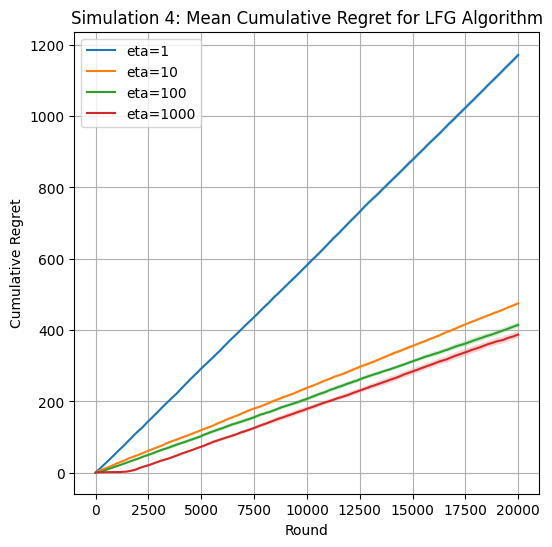

In [98]:
import numpy as np
import matplotlib.pyplot as plt

class LFG:
    def __init__(self, n_arms, m, mu, p, r, eta, R_star):
        self.n_arms = n_arms
        self.m = m
        self.mu_true = mu
        self.p = p
        self.r = r
        self.eta = eta
        self.R_star = R_star

        self.h = np.zeros(n_arms)
        self.total_rewards = np.zeros(n_arms)
        self.mu_hat = np.zeros(n_arms)
        self.UCB = np.ones(n_arms)
        self.Q = np.zeros(n_arms)
        self.d = np.zeros(n_arms)
        self.T = 0
        self.regret = 0
        self.fair_regret = 0
        self.cumulative_mean_reward = 0

        self.cumulative_regrets = []
        self.average_regrets = []
        self.cumulative_fair_regrets = []
        self.average_fair_regrets = []

    def get_awake_arms(self):
        return {arm for arm in range(self.n_arms) if np.random.rand() < self.p[arm]}

    def update_UCB(self):
        for i in range(self.n_arms):
            if self.h[i] > 0:
                self.UCB[i] = min(self.mu_hat[i] + np.sqrt((3 * np.log(self.T)) / (2 * self.h[i])), 1)
            else:
                self.UCB[i] = 1

    def update_queue(self):
        for i in range(self.n_arms):
            self.Q[i] = max(self.Q[i] + self.r[i] - self.d[i], 0)

    def select_super_arm(self, available_arms):
        super_arm = set()
        m_star = min(self.m, len(available_arms))
        for _ in range(m_star):
            best_arm = max(available_arms - super_arm, key=lambda i: self.Q[i] + self.UCB[i] * self.eta * self.mu_hat[i])
            super_arm.add(best_arm)
        return super_arm

    def play_arms(self, super_arm):
        rewards = {i: np.random.binomial(1, self.mu_true[i]) for i in super_arm}
        return rewards

    def get_optimal_reward(self, available_arms):
        best_arms = sorted([self.mu_true[i] for i in available_arms], reverse=True)[:self.m]
        return sum(best_arms)

    def get_fair_optimal_reward(self):
        expected_reward = sum(self.total_rewards) / self.T
        return self.R_star - expected_reward

    def run(self, rounds):
        for t in range(1, rounds + 1):
            self.T = t

            available_arms = self.get_awake_arms()

            self.update_UCB()
            self.update_queue()

            super_arm = self.select_super_arm(available_arms)
            
            self.d = np.zeros(self.n_arms)
            
            if super_arm:
                rewards = self.play_arms(super_arm)
                
                for i in super_arm:
                    self.total_rewards[i] += rewards[i]
                    self.h[i] += 1
                    self.mu_hat[i] = self.total_rewards[i] / self.h[i]
                    self.d[i] = 1
                
                optimal_reward = self.get_optimal_reward(available_arms)
                obtained_mean_reward = sum(self.mu_true[i] for i in super_arm)
                self.cumulative_mean_reward += obtained_mean_reward
                self.regret += (optimal_reward - obtained_mean_reward)
                #self.fair_regret =  self.get_fair_optimal_reward()
                self.fair_regret = (t * self.R_star) - self.cumulative_mean_reward
                

            self.cumulative_regrets.append(self.regret)
            self.cumulative_fair_regrets.append(self.fair_regret)
            avg_regret = self.regret / t
            avg_fair_regret = self.fair_regret / t
            self.average_regrets.append(avg_regret)
            self.average_fair_regrets.append(avg_fair_regret)

        return self.cumulative_regrets, self.average_regrets, self.cumulative_fair_regrets, self.average_fair_regrets

def average_simulations(n_simulations, lfg_class, *args):
    all_cumulative_regrets = []
    all_average_regrets = []
    all_cumulative_fair_regrets = []
    all_average_fair_regrets = []

    for _ in range(n_simulations):
        lfg = lfg_class(*args)
        cumulative_regrets, average_regrets, cumulative_fair_regrets, average_fair_regrets = lfg.run(rounds)
        all_cumulative_regrets.append(cumulative_regrets)
        all_average_regrets.append(average_regrets)
        all_cumulative_fair_regrets.append(cumulative_fair_regrets)
        all_average_fair_regrets.append(average_fair_regrets)

    mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
    mean_average_regrets = np.mean(all_average_regrets, axis=0)
    mean_cumulative_fair_regrets = np.mean(all_cumulative_fair_regrets, axis=0)
    mean_average_fair_regrets = np.mean(all_average_fair_regrets, axis=0)

    return mean_cumulative_regrets, mean_average_regrets, mean_cumulative_fair_regrets, mean_average_fair_regrets



def plot_cumulative_regret(mean_results, std_errors, etas, rounds):
    plt.figure(figsize=(6, 6))
    for eta, mean_cumulative_regrets, se in zip(etas, mean_results, std_errors):
        plt.plot(range(1, rounds + 1), mean_cumulative_regrets, label=f'eta={eta}')
        plt.fill_between(
            range(1, rounds + 1), 
            mean_cumulative_regrets - 2 * se, 
            mean_cumulative_regrets + 2 * se, 
            alpha=0.2
        )
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.title('Simulation 4: Mean Cumulative Regret for LFG Algorithm')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_average_fairness_regret(mean_results, etas, rounds):
    plt.figure(figsize=(6, 6))
    for eta, (_, _, _, mean_average_fair_regrets) in zip(etas, mean_results):
        plt.plot(range(1, rounds + 1), mean_average_fair_regrets, label=f'eta={eta}')
    plt.xlabel('Round')
    plt.ylabel('Average Fairness Regret')
    plt.title('Mean Average Fairness Regret Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()




# Parameters
n_arms = 3
m = 2
mu = [0.3, 0.5, 0.7]
p = [0.9, 0.8, 0.7]
r = [0.5, 0.6, 0.4]
etas = [1, 10, 100, 1000]
rounds = 20000
n_simulations = 10


# Run experiments for different eta values and collect results for all simulations
mean_results = []
std_errors = []
for eta in etas:
    cumulative_regrets_simulations = []

    for _ in range(n_simulations):
        lfg = LFG(n_arms, m, mu, p, r, eta, R_star)
        cumulative_regrets, _, _, _ = lfg.run(rounds)
        cumulative_regrets_simulations.append(cumulative_regrets)

    # Calculate mean cumulative regrets and standard errors
    mean_cumulative_regrets = np.mean(cumulative_regrets_simulations, axis=0)
    se_cumulative_regrets = np.std(cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)

    mean_results.append(mean_cumulative_regrets)
    std_errors.append(se_cumulative_regrets)

# Plot Mean Cumulative Regret Over Time with 2 SE
plot_cumulative_regret(mean_results, std_errors, etas, rounds)




4

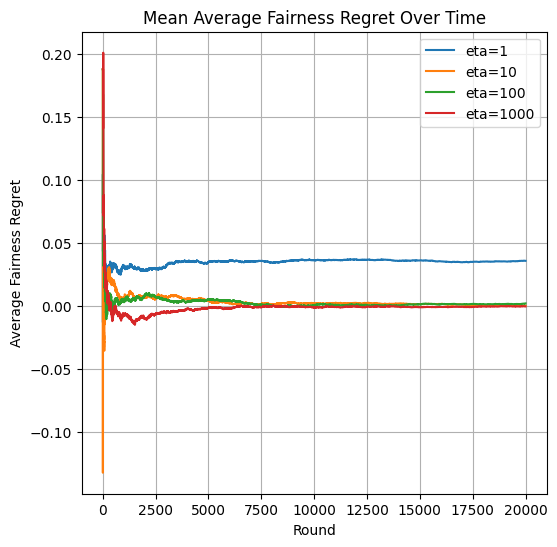

In [67]:
import numpy as np
import matplotlib.pyplot as plt

class LFG:
    def __init__(self, n_arms, m, mu, p, r, eta, R_star):
        self.n_arms = n_arms
        self.m = m
        self.mu_true = mu
        self.p = p
        self.r = r
        self.eta = eta
        self.R_star = R_star

        self.h = np.zeros(n_arms)
        self.total_rewards = np.zeros(n_arms)
        self.mu_hat = np.zeros(n_arms)
        self.UCB = np.ones(n_arms)
        self.Q = np.zeros(n_arms)
        self.d = np.zeros(n_arms)
        self.T = 0
        self.regret = 0
        self.fair_regret = 0
        self.cumulative_mean_reward = 0

        self.cumulative_regrets = []
        self.average_regrets = []
        self.cumulative_fair_regrets = []
        self.average_fair_regrets = []

    def get_awake_arms(self):
        return {arm for arm in range(self.n_arms) if np.random.rand() < self.p[arm]}

    def update_UCB(self):
        for i in range(self.n_arms):
            if self.h[i] > 0:
                self.UCB[i] = min(self.mu_hat[i] + np.sqrt((3 * np.log(self.T)) / (2 * self.h[i])), 1)
            else:
                self.UCB[i] = 1

    def update_queue(self):
        for i in range(self.n_arms):
            self.Q[i] = max(self.Q[i] + self.r[i] - self.d[i], 0)

    def select_super_arm(self, available_arms):
        super_arm = set()
        m_star = min(self.m, len(available_arms))
        for _ in range(m_star):
            best_arm = max(available_arms - super_arm, key=lambda i: self.Q[i] + self.UCB[i] * self.eta * self.mu_hat[i])
            super_arm.add(best_arm)
        return super_arm

    def play_arms(self, super_arm):
        rewards = {i: np.random.binomial(1, self.mu_true[i]) for i in super_arm}
        return rewards

    def get_optimal_reward(self, available_arms):
        best_arms = sorted([self.mu_true[i] for i in available_arms], reverse=True)[:self.m]
        return sum(best_arms)

    def get_fair_optimal_reward(self):
        expected_reward = sum(self.total_rewards) / self.T
        return self.R_star - expected_reward

    def run(self, rounds):
        for t in range(1, rounds + 1):
            self.T = t

            available_arms = self.get_awake_arms()

            self.update_UCB()
            self.update_queue()

            super_arm = self.select_super_arm(available_arms)
            
            self.d = np.zeros(self.n_arms)
            
            if super_arm:
                rewards = self.play_arms(super_arm)
                
                for i in super_arm:
                    self.total_rewards[i] += rewards[i]
                    self.h[i] += 1
                    self.mu_hat[i] = self.total_rewards[i] / self.h[i]
                    self.d[i] = 1
                
                optimal_reward = self.get_optimal_reward(available_arms)
                obtained_mean_reward = sum(self.mu_true[i] for i in super_arm)
                self.cumulative_mean_reward += obtained_mean_reward
                self.regret += (optimal_reward - obtained_mean_reward)
                self.fair_regret = (t * self.R_star) - self.cumulative_mean_reward

            self.cumulative_regrets.append(self.regret)
            self.cumulative_fair_regrets.append(self.fair_regret)
            avg_regret = self.regret / t
            avg_fair_regret = self.fair_regret / t
            self.average_regrets.append(avg_regret)
            self.average_fair_regrets.append(avg_fair_regret)

        return self.cumulative_regrets, self.average_regrets, self.cumulative_fair_regrets, self.average_fair_regrets

def average_simulations(n_simulations, lfg_class, *args):
    all_cumulative_regrets = []
    all_average_regrets = []
    all_cumulative_fair_regrets = []
    all_average_fair_regrets = []

    for _ in range(n_simulations):
        lfg = lfg_class(*args)
        cumulative_regrets, average_regrets, cumulative_fair_regrets, average_fair_regrets = lfg.run(rounds)
        all_cumulative_regrets.append(cumulative_regrets)
        all_average_regrets.append(average_regrets)
        all_cumulative_fair_regrets.append(cumulative_fair_regrets)
        all_average_fair_regrets.append(average_fair_regrets)

    mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
    mean_average_regrets = np.mean(all_average_regrets, axis=0)
    mean_cumulative_fair_regrets = np.mean(all_cumulative_fair_regrets, axis=0)
    mean_average_fair_regrets = np.mean(all_average_fair_regrets, axis=0)

    return mean_cumulative_regrets, mean_average_regrets, mean_cumulative_fair_regrets, mean_average_fair_regrets

def plot_cumulative_regret(mean_results, std_errors, etas, rounds):
    plt.figure(figsize=(8, 6))
    for eta, mean_cumulative_regrets, se in zip(etas, mean_results, std_errors):
        plt.plot(range(1, rounds + 1), mean_cumulative_regrets, label=f'eta={eta}')
        plt.fill_between(
            range(1, rounds + 1), 
            mean_cumulative_regrets - 2 * se, 
            mean_cumulative_regrets + 2 * se, 
            alpha=0.2
        )
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.title('Mean Cumulative Regret Over Time with 2 SE')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_average_fairness_regret(mean_results, etas, rounds):
    plt.figure(figsize=(6, 6))
    for eta, (_, _, _, mean_average_fair_regrets) in zip(etas, mean_results):
        plt.plot(range(1, rounds + 1), mean_average_fair_regrets, label=f'eta={eta}')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Fairness Regret')
    plt.title('Simulation 4: Mean Cumlative Fairness Regret for LFG Algorithm')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
n_arms = 3
m = 2
mu = [0.3, 0.5, 0.7]
p = [0.9, 0.8, 0.7]
r = [0.5, 0.6, 0.4]
etas = [1, 10, 100, 1000]
rounds = 20000
n_simulations = 1

# Run experiments for different eta values and collect results for all simulations
mean_results = []
std_errors = []

for eta in etas:
    cumulative_regrets_simulations = []

    for _ in range(n_simulations):
        lfg = LFG(n_arms, m, mu, p, r, eta, R_star)
        cumulative_regrets, _, _, _ = lfg.run(rounds)
        cumulative_regrets_simulations.append(cumulative_regrets)

    # Calculate mean cumulative regrets and standard errors
    mean_cumulative_regrets = np.mean(cumulative_regrets_simulations, axis=0)
    se_cumulative_regrets = np.std(cumulative_regrets_simulations, axis=0) / np.sqrt(n_simulations)

    mean_results.append((mean_cumulative_regrets, 
                         None,  # Placeholder for mean_average_regrets
                         None,  # Placeholder for mean_cumulative_fair_regrets
                         None)) # Placeholder for mean_average_fair_regrets
    std_errors.append(se_cumulative_regrets)

# Calculate mean average regrets and mean average fairness regrets
for i, eta in enumerate(etas):
    lfg = LFG(n_arms, m, mu, p, r, eta, R_star)
    _, mean_average_regrets, _, mean_average_fair_regrets = lfg.run(rounds)
    mean_results[i] = (mean_results[i][0], 
                       mean_average_regrets, 
                       mean_results[i][2], 
                       mean_average_fair_regrets)



# Plot Mean Average Fairness Regret Over Time
plot_average_fairness_regret(mean_results, etas, rounds)


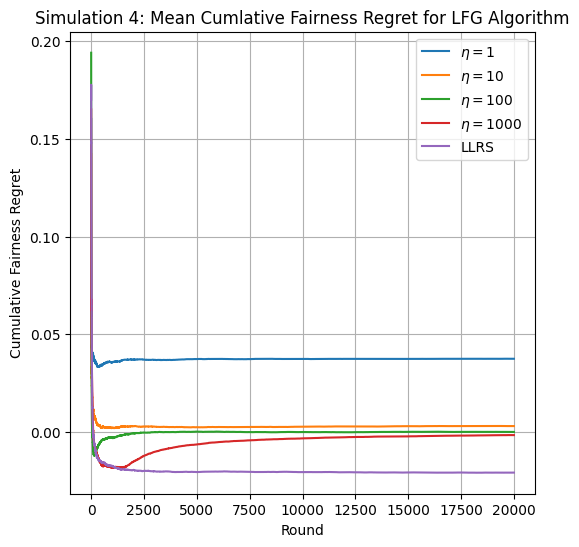

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Define LLRS class
class LLRS:
    def __init__(self, n_arms, m, mu_true, p, R_star):
        self.n_arms = n_arms
        self.m = m
        self.mu_true = mu_true  # True mean rewards of each arm
        self.p = p  # Probability that each arm is available (awake)
        self.R_star = R_star  # Optimal reward for fairness regret calculation

        self.h = np.zeros(n_arms)  # Number of times each arm is played
        self.total_rewards = np.zeros(n_arms)  # Total rewards obtained from each arm
        self.mu_hat = np.zeros(n_arms)  # Empirical mean rewards of each arm
        self.UCB = np.ones(n_arms)  # UCB values for each arm
        self.T = 0  # Total number of rounds
        self.regret = 0  # Cumulative regret
        self.fair_regret = 0  # Cumulative fairness regret
        self.cumulative_mean_reward = 0  # Cumulative mean reward
        
        self.cumulative_regrets = []
        self.average_regrets = []
        self.cumulative_fair_regrets = []
        self.average_fair_regrets = []
        

    def get_awake_arms(self):
        """Determine which arms are awake based on their availability probabilities."""
        return {arm for arm in range(self.n_arms) if np.random.rand() < self.p[arm]}

    def update_UCB(self):
        """Update UCB values based on current empirical mean rewards and number of plays."""
        for i in range(self.n_arms):
            if self.h[i] > 0:
                self.UCB[i] = min(self.mu_hat[i] + np.sqrt((3 * np.log(self.T)) / (2 * self.h[i])), 1)
            else:
                self.UCB[i] = 1  # Ensure unplayed arms have a high UCB to be explored

    def select_super_arm(self, available_arms):
        """Select the super arm (a subset of available arms) that maximizes the sum of UCB values."""
        super_arm = set()
        m_star = min(self.m, len(available_arms))  # Ensure we don't select more than m arms
        
        for _ in range(m_star):
            best_arm = max(available_arms - super_arm, key=lambda i: self.UCB[i])
            super_arm.add(best_arm)
        
        return super_arm

    def play_arms(self, super_arm):
        """Simulate playing the selected arms and obtain rewards."""
        rewards = {i: np.random.binomial(1, self.mu_true[i]) for i in super_arm}
        return rewards

    def get_optimal_reward(self, available_arms):
        """Calculate the optimal reward by selecting the top m arms from the available arms."""
        best_arms = sorted([self.mu_true[i] for i in available_arms], reverse=True)[:self.m]
        return sum(best_arms)

    def run(self, rounds):
        """Run the LLRS algorithm for a specified number of rounds."""
        selection_count = np.zeros((self.n_arms, rounds))
        
        for t in range(1, rounds + 1):
            self.T = t
            available_arms = self.get_awake_arms()
            self.update_UCB()
            super_arm = self.select_super_arm(available_arms)
            
            if super_arm:
                rewards = self.play_arms(super_arm)
                for i in super_arm:
                    self.total_rewards[i] += rewards[i]
                    self.h[i] += 1
                    self.mu_hat[i] = self.total_rewards[i] / self.h[i]
                    selection_count[i, t-1] += 1

                optimal_reward = self.get_optimal_reward(available_arms)
                obtained_mean_reward = sum(self.mu_true[i] for i in super_arm)
                self.cumulative_mean_reward += obtained_mean_reward
                self.regret += (optimal_reward - obtained_mean_reward)
                self.fair_regret = (t * self.R_star) - self.cumulative_mean_reward

            self.cumulative_regrets.append(self.regret)
            self.cumulative_fair_regrets.append(self.fair_regret)
            avg_regret = self.regret / t
            avg_fair_regret = self.fair_regret / t
            self.average_regrets.append(avg_regret)
            self.average_fair_regrets.append(avg_fair_regret)

        selection_fraction = np.cumsum(selection_count, axis=1) / np.arange(1, rounds + 1)
        return self.cumulative_regrets, self.average_regrets, self.cumulative_fair_regrets, self.average_fair_regrets

def average_simulations(n_simulations, algorithm_class, *args):
    all_fair_regrets = []

    for _ in range(n_simulations):
        algorithm = algorithm_class(*args)
        fair_regrets = algorithm.run(rounds)
        all_fair_regrets.append(fair_regrets)

    mean_fair_regrets = np.mean(all_fair_regrets, axis=0)
    return mean_fair_regrets

def plot_average_fairness_regret(mean_results, etas, rounds, llrs_fairness_regret=None):
    plt.figure(figsize=(6, 6))
    
    # Plot the mean average fairness regret for each eta
    for eta, (_, _, _, mean_average_fair_regrets) in zip(etas, mean_results):
        plt.plot(range(1, rounds + 1), mean_average_fair_regrets, label=f'$\\eta={eta}$')

    # Plot LLRS fairness regret if provided
    if llrs_fairness_regret is not None:
        plt.plot(range(1, rounds + 1), llrs_fairness_regret, label='LLRS')
    
    plt.xlabel('Round')
    plt.ylabel('Cumulative Fairness Regret')
    plt.title('Simulation 4: Mean Cumlative Fairness Regret for LFG Algorithm')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
n_arms = 3
m = 2
mu = [0.3, 0.5, 0.7]
p = [0.9, 0.8, 0.7]
etas = [1, 10, 100, 1000]
rounds = 20000
n_simulations = 100

# Run LFG experiments for different eta values and collect results for all simulations
mean_results = []
for eta in etas:
    cumulative_regrets_simulations = []
    
    for _ in range(n_simulations):
        lfg = LFG(n_arms, m, mu, p, r, eta, R_star)
        _, _, _, average_fair_regrets = lfg.run(rounds)
        cumulative_regrets_simulations.append(average_fair_regrets)

    mean_average_fair_regrets = np.mean(cumulative_regrets_simulations, axis=0)
    mean_results.append((None, None, None, mean_average_fair_regrets))

# Compute the average fairness regret for LLRS
llrs_fairness_regrets = []
for _ in range(n_simulations):
    llrs = LLRS(n_arms, m, mu, p, R_star)
    _, _, _, fair_regrets = llrs.run(rounds)
    llrs_fairness_regrets.append(fair_regrets)

mean_llrs_fairness_regret = np.mean(llrs_fairness_regrets, axis=0)

# Plot Mean Average Fairness Regret Over Time
plot_average_fairness_regret(mean_results, etas, rounds, mean_llrs_fairness_regret)



Plotting selection counts for the 3 arms: 

<>:100: SyntaxWarning: invalid escape sequence '\e'
<>:100: SyntaxWarning: invalid escape sequence '\e'
C:\Users\armaa\AppData\Local\Temp\ipykernel_7892\1770315415.py:100: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(range(1, rounds + 1), mean_selection_fractions[arm, idx], label=f'$\eta={eta}$')


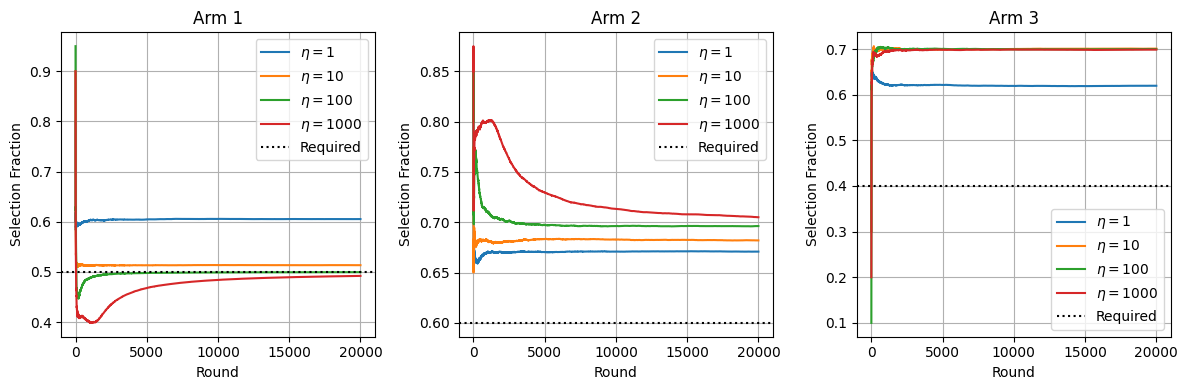

In [104]:
import numpy as np
import matplotlib.pyplot as plt

class LFG:
    def __init__(self, n_arms, m, mu, p, r, eta, R_star):
        self.n_arms = n_arms
        self.m = m
        self.mu_true = mu
        self.p = p
        self.r = r
        self.eta = eta
        self.R_star = R_star

        self.h = np.zeros(n_arms)
        self.total_rewards = np.zeros(n_arms)
        self.mu_hat = np.zeros(n_arms)
        self.UCB = np.ones(n_arms)
        self.Q = np.zeros(n_arms)
        self.d = np.zeros(n_arms)
        self.T = 0

        # Track the number of times each arm is selected
        self.selection_count = np.zeros((n_arms,))

    def get_awake_arms(self):
        return {arm for arm in range(self.n_arms) if np.random.rand() < self.p[arm]}

    def update_UCB(self):
        for i in range(self.n_arms):
            if self.h[i] > 0:
                self.UCB[i] = min(self.mu_hat[i] + np.sqrt((3 * np.log(self.T)) / (2 * self.h[i])), 1)
            else:
                self.UCB[i] = 1

    def update_queue(self):
        for i in range(self.n_arms):
            self.Q[i] = max(self.Q[i] + self.r[i] - self.d[i], 0)

    def select_super_arm(self, available_arms):
        super_arm = set()
        m_star = min(self.m, len(available_arms))
        for _ in range(m_star):
            best_arm = max(available_arms - super_arm, key=lambda i: self.Q[i] + self.UCB[i] * self.eta * self.mu_hat[i])
            super_arm.add(best_arm)
        return super_arm

    def play_arms(self, super_arm):
        rewards = {i: np.random.binomial(1, self.mu_true[i]) for i in super_arm}
        return rewards

    def run(self, rounds):
        selection_fraction = np.zeros((self.n_arms, rounds))

        for t in range(1, rounds + 1):
            self.T = t

            available_arms = self.get_awake_arms()

            self.update_UCB()
            self.update_queue()

            super_arm = self.select_super_arm(available_arms)
            self.d = np.zeros(self.n_arms)

            if super_arm:
                rewards = self.play_arms(super_arm)
                
                for i in super_arm:
                    self.total_rewards[i] += rewards[i]
                    self.h[i] += 1
                    self.mu_hat[i] = self.total_rewards[i] / self.h[i]
                    self.d[i] = 1
                    self.selection_count[i] += 1  # Track how many times arm i is selected

            # Update selection fraction at this round
            selection_fraction[:, t - 1] = self.selection_count / t

        return selection_fraction

def average_selection_fraction(n_simulations, lfg_class, *args, rounds):
    all_selection_fractions = np.zeros((n_simulations, args[0], rounds))

    for sim in range(n_simulations):
        lfg = lfg_class(*args)
        selection_fraction = lfg.run(rounds)
        all_selection_fractions[sim, :, :] = selection_fraction

    mean_selection_fraction = np.mean(all_selection_fractions, axis=0)
    return mean_selection_fraction

def plot_selection_fraction(mean_selection_fractions, r, etas, rounds):
    n_arms = mean_selection_fractions.shape[0]
    
    # Create subplots with size (12, 4)
    fig, axes = plt.subplots(1, n_arms, figsize=(12, 4), sharey=False)
    
    for arm in range(n_arms):
        ax = axes[arm]
        for idx, eta in enumerate(etas):
            ax.plot(range(1, rounds + 1), mean_selection_fractions[arm, idx], label=f'$\eta={eta}$')
        
        # Add dotted black line for r[arm]
        ax.axhline(y=r[arm], color='black', linestyle=':', label=f'Required')

        ax.set_xlabel('Round')
        ax.set_title(f'Arm {arm + 1}')
        ax.set_ylabel('Selection Fraction')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Parameters
n_arms = 3
m = 2
mu = [0.3, 0.5, 0.7]
p = [0.9, 0.8, 0.7]
r = [0.5, 0.6, 0.4]
etas = [1, 10, 100, 1000]
rounds = 20000
n_simulations = 20

# Calculate average selection fraction over simulations for each eta
mean_selection_fractions = np.zeros((n_arms, len(etas), rounds))

for idx, eta in enumerate(etas):
    mean_selection_fractions[:, idx, :] = average_selection_fraction(n_simulations, LFG, n_arms, m, mu, p, r, eta, R_star, rounds=rounds)

# Plot the results
plot_selection_fraction(mean_selection_fractions, r, etas, rounds)
